In [1]:
#pip install boto3 --user
#pip install pandas-profiling[notebook] --user
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import pandas as pd
import numpy as np
import boto3
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import seaborn as sns
import fun_eda, fun_s3

# Análisis exploratorio de datos

# 1. Base original

In [3]:
bucket_name = 'movicovid'
fname = '{}/{}/{}'.format('data', 'dataforgood', 'movimientos_entre_administraciones_08062020.csv')

In [4]:
original_data = fun_s3.abre_file_como_df(bucket_name, fname)
#s3.download_file(bucket_name, fname, 'movimientos_entre_administraciones_08062020.csv')

In [5]:
original_data.head()
#original_data.columns

difference  baseline_people_moving  crisis_people_moving  percent_change  \
0         3.6                    61.4                    65        5.769231   
1      -161.2                 29851.2                 29690       -0.539994   
2        11.4                    18.6                    30       58.163265   
3        -0.4                    11.4                    11       -3.225806   
4         7.8                   198.2                   206        3.915663   

   standard_z_score starting_region_name ending_region_name  \
0          0.654005         Azcapotzalco            Acolman   
1         -0.512844        Benito Juárez      Benito Juárez   
2          3.468910        Benito Juárez         Nextlalpan   
3         -0.099075            Tultitlán          Coyotepec   
4          0.573158        Benito Juárez        Chicoloapan   

   starting_location  ending_location  length_km  \
0             590926           591495  25.572917   
1             589331           589331   0.086858   
2             589331           589332  37.176444   
3             589238           593432  17.062451   
4             589331           590743  27.783948   

                                            geometry  start_lat  start_lon  \
0  LINESTRING (-99.16310471754808 19.488262625130...  19.485337 -99.182136   
1  LINESTRING (-99.16324373671165 19.374161793603...  19.380692 -99.161232   
2  LINESTRING (-99.163330078125 19.3740310041428,...  19.380692 -99.161232   
3  LINESTRING (-99.16359641335227 19.632239857166...  19.626197 -99.145332   
4  LINESTRING (-99.16366429004854 19.374044420647...  19.380692 -99.161232   

     end_lat    end_lon      hora  hr       fecha  
0  19.633768 -98.919868  00:00:00   0  2020-02-27  
1  19.380692 -99.161232  00:00:00   0  2020-02-27  
2  19.726623 -99.076491  00:00:00   0  2020-02-27  
3  19.787257 -99.225722  00:00:00   0  2020-02-27  
4  19.405405 -98.878142  00:00:00   0  2020-02-27

In [6]:
####################################   CAMBIO TIPO DE VARIABLES  ####################################
original_data['starting_region_name'] = original_data['starting_region_name'].astype('category')
original_data['ending_region_name'] = original_data['ending_region_name'].astype('category')
original_data['fecha'] = pd.to_datetime(original_data['fecha'])
original_data['hr'] = original_data['hora'].str.slice(start=0, stop=2).astype(int)

In [7]:
#################################### INFORMACION GENERAL ####################################
# Informacion general de la base
# Clasificación de las variables por tipo
[numeric_variables, categorical_variables, dates_variables, string_variables] = fun_eda.info_type_of_vars(original_data)
# Imprime a pantalla las variables por tipo
fun_eda.print_info_type_of_vars(numeric_variables, categorical_variables, dates_variables, string_variables)

Numericas:
 ['difference' 'baseline_people_moving' 'crisis_people_moving'
 'percent_change' 'standard_z_score' 'starting_location' 'ending_location'
 'length_km' 'start_lat' 'start_lon' 'end_lat' 'end_lon' 'hr'] 
 Total:  13 

Categoricas:
 ['starting_region_name' 'ending_region_name'] 
 Total:  2 

Formato Fecha: 
 ['fecha'] 
 Total:  1 

Foramto texto: 
 ['geometry' 'hora'] 
 Total:  2 



 ## Estadísticas descriptivas
 
 ### a) Variables numéricas

In [8]:
fun_eda.descriptive_stats_for_numeric_vars(original_data, numeric_variables).round(2)

difference  baseline_people_moving  crisis_people_moving  \
n_observations     284495.00               284495.00             284495.00   
max                130674.20               222605.40             221390.00   
min               -144357.00                   10.00                 10.00   
mean                   -5.11                 2409.01               2403.90   
std_dev              5379.22                11937.08              12489.86   
25%                  -200.20                   64.20                 32.00   
median                -42.20                  200.20                103.00   
75%                    -3.60                  763.20                423.00   
kurtosis              421.41                  131.25                 78.85   
skewness               -2.62                   10.08                  8.15   
n_unique_values     31628.00                 8253.00              16381.00   
%_missings              0.00                    0.00                  0.00   
Top1_most_common       -2.00                   19.80                 11.00   
Top2_most_common        0.00                   17.00                 10.00   
Top3_most_common       -1.00                   13.00                 12.00   

                  percent_change  standard_z_score  starting_location  \
n_observations         284495.00         284495.00          284495.00   
max                      2161.90              4.00          593432.00   
min                       -98.56             -4.00          589187.00   
mean                      -32.19             -1.89          590317.19   
std_dev                    40.22              2.36            1241.36   
25%                       -61.76             -4.00          589245.00   
median                    -37.59             -2.46          589867.00   
75%                        -4.24             -0.38          591201.00   
kurtosis                  100.09              0.04              -0.18   
skewness                    4.16              0.96               0.98   
n_unique_values        153648.00         106324.00              66.00   
%_missings                  0.00              0.00               0.00   
Top1_most_common            0.00             -4.00          589294.00   
Top2_most_common          -16.67              4.00          590527.00   
Top3_most_common          -28.57              0.00          589198.00   

                  ending_location  length_km  start_lat  start_lon    end_lat  \
n_observations          284495.00  284495.00  276116.00  276116.00  276116.00   
max                     593432.00      82.37      19.82     -98.72      19.82   
min                     589187.00       0.00      19.12     -99.48      19.12   
mean                    590302.83      13.45      19.47     -99.10      19.47   
std_dev                   1239.51       9.30       0.16       0.14       0.16   
25%                     589245.00       5.39      19.35     -99.18      19.35   
median                  589820.00      12.66      19.43     -99.12      19.43   
75%                     591093.00      19.80      19.60     -99.00      19.60   
kurtosis                    -0.12      -0.05      -0.80      -0.19      -0.79   
skewness                     1.00       0.60       0.17       0.40       0.18   
n_unique_values             66.00  274819.00      66.00      66.00      66.00   
%_missings                   0.00       0.00       2.95       2.95       2.95   
Top1_most_common        589294.00       0.00      19.43     -99.15      19.43   
Top2_most_common        590527.00       2.31      19.43     -99.20      19.43   
Top3_most_common        589198.00      11.76      19.50     -99.12      19.50   

                    end_lon         hr  
n_observations    276116.00  284495.00  
max                  -98.72      16.00  
min                  -99.48       0.00  
mean                 -99.10       7.77  
std_dev                0.14       6.68  
25%                  -99.18       0.00  
median          

### b) Variables categoricas

In [9]:
fun_eda.descriptive_stats_for_categorical_vars(original_data,['hora', 'starting_region_name', 'ending_region_name', 'geometry'])

hora  \
n_observations                            284495   
mode                                    00:00:00   
num_categories                                 3   
categories        [00:00:00, 08:00:00, 16:00:00]   
n_unique_values                                3   
n_missings                                     0   
%_missings                                     0   
Top1_most_common                        00:00:00   
Top2_most_common                        16:00:00   
Top3_most_common                        08:00:00   

                                               starting_region_name  \
n_observations                                               284495   
mode                                                     Cuauhtémoc   
num_categories                                                   66   
categories        [Azcapotzalco, Benito Juárez, Tultitlán, Tlalp...   
n_unique_values                                                  66   
n_missings                                                        0   
%_missings                                                        0   
Top1_most_common                                         Cuauhtémoc   
Top2_most_common                                     Miguel Hidalgo   
Top3_most_common                                  Gustavo A. Madero   

                                                 ending_region_name  \
n_observations                                               284495   
mode                                                     Cuauhtémoc   
num_categories                                                   66   
categories        [Acolman, Benito Juárez, Nextlalpan, Coyotepec...   
n_unique_values                                                  66   
n_missings                                                        0   
%_missings                                                        0   
Top1_most_common                                         Cuauhtémoc   
Top2_most_common                                     Miguel Hidalgo   
Top3_most_common                                  Gustavo A. Madero   

                                                           geometry  
n_observations                                               284495  
mode              LINESTRING (-99.08569335937501 19.756363895671...  
num_categories                                               275890  
categories        [LINESTRING (-99.16310471754808 19.48826262513...  
n_unique_values                                              275890  
n_missings                                                        0  
%_missings                                                        0  
Top1_most_common  LINESTRING (-99.08569335937501 19.756363895671...  
Top2_most_common  LINESTRING (-98.90991210937499 19.570141807849...  
Top3_most_common  LINESTRING (-98.75610351562499 19.155546224916...

In [10]:
print("Primer dia:", original_data['fecha'].max(), "\nUltimo dia:", original_data['fecha'].min())
#original_data['fecha'].describe()

Primer dia: 2020-06-07 00:00:00 
Ultimo dia: 2020-02-27 00:00:00


In [11]:
#################################### PANDAS PROFILING  ####################################

#profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
#profile.to_widgets()
#profile.to_file("~/bj/Profile_report.html")

# 2. Variables de interés

In [12]:
data = original_data[['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name', 'percent_change',
                     'ending_region_name', 'length_km', 'hr','fecha']].copy()

In [13]:
data.shape

(284495, 9)

## 2.1 Registros Duplicados

Set original: 284,495

Set sin duplicados: 279,062

Duplicados: 5,433

In [14]:
####################################  DROP REGISTROS DUPLICADOS
# elimina todos, menos el primero
data.drop_duplicates(subset = ['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name',
                               'percent_change', 'ending_region_name', 'length_km', 'hr','fecha'], 
                              keep = 'first', inplace = True) 

In [15]:
data.shape

(279062, 9)

In [16]:
delegaciones = ["Álvaro Obregón", 
                "Azcapotzalco",
                "Benito Juárez",
                "Coyoacán",	
                "Cuajimalpa de Morelos",
                "Cuauhtémoc",
                "Gustavo A. Madero",
                "Iztacalco",
                "Iztapalapa",
                "La Magdalena Contreras",
                "Miguel Hidalgo",
                "Milpa Alta",
                "Tláhuac",
                "Tlalpan",
                "Venustiano Carranza",
                "Xochimilco"]

In [17]:
####################################   TRANSFORMACION DE VARIABLES  ####################################

#### Añado columnas que indican si el Origen/Destino es en CDMX
data = data.assign(ori_cdmx=np.where(data["starting_region_name"].isin(delegaciones), 'CDMX', 'Otro'), 
                   des_cdmx=np.where(data["ending_region_name"].isin(delegaciones), 'CDMX', 'Otro'))

### Añado una columna que contabilice el numero de semanas
data['num_semana'] = data['fecha'].dt.week

### Añado una columna para el dia de la semana
dict_days = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
data['dia_semana'] = data['fecha'].dt.dayofweek.map(dict_days)

### Anado una columna para identificar la ruta
data['ruta'] = data['starting_region_name'].astype(str) + " - " + data['ending_region_name'].astype(str)


In [18]:
fun_eda.descriptive_stats_for_numeric_vars(original_data, numeric_variables).round(2)

difference  baseline_people_moving  crisis_people_moving  \
n_observations     284495.00               284495.00             284495.00   
max                130674.20               222605.40             221390.00   
min               -144357.00                   10.00                 10.00   
mean                   -5.11                 2409.01               2403.90   
std_dev              5379.22                11937.08              12489.86   
25%                  -200.20                   64.20                 32.00   
median                -42.20                  200.20                103.00   
75%                    -3.60                  763.20                423.00   
kurtosis              421.41                  131.25                 78.85   
skewness               -2.62                   10.08                  8.15   
n_unique_values     31628.00                 8253.00              16381.00   
%_missings              0.00                    0.00                  0.00   
Top1_most_common       -2.00                   19.80                 11.00   
Top2_most_common        0.00                   17.00                 10.00   
Top3_most_common       -1.00                   13.00                 12.00   

                  percent_change  standard_z_score  starting_location  \
n_observations         284495.00         284495.00          284495.00   
max                      2161.90              4.00          593432.00   
min                       -98.56             -4.00          589187.00   
mean                      -32.19             -1.89          590317.19   
std_dev                    40.22              2.36            1241.36   
25%                       -61.76             -4.00          589245.00   
median                    -37.59             -2.46          589867.00   
75%                        -4.24             -0.38          591201.00   
kurtosis                  100.09              0.04              -0.18   
skewness                    4.16              0.96               0.98   
n_unique_values        153648.00         106324.00              66.00   
%_missings                  0.00              0.00               0.00   
Top1_most_common            0.00             -4.00          589294.00   
Top2_most_common          -16.67              4.00          590527.00   
Top3_most_common          -28.57              0.00          589198.00   

                  ending_location  length_km  start_lat  start_lon    end_lat  \
n_observations          284495.00  284495.00  276116.00  276116.00  276116.00   
max                     593432.00      82.37      19.82     -98.72      19.82   
min                     589187.00       0.00      19.12     -99.48      19.12   
mean                    590302.83      13.45      19.47     -99.10      19.47   
std_dev                   1239.51       9.30       0.16       0.14       0.16   
25%                     589245.00       5.39      19.35     -99.18      19.35   
median                  589820.00      12.66      19.43     -99.12      19.43   
75%                     591093.00      19.80      19.60     -99.00      19.60   
kurtosis                    -0.12      -0.05      -0.80      -0.19      -0.79   
skewness                     1.00       0.60       0.17       0.40       0.18   
n_unique_values             66.00  274819.00      66.00      66.00      66.00   
%_missings                   0.00       0.00       2.95       2.95       2.95   
Top1_most_common        589294.00       0.00      19.43     -99.15      19.43   
Top2_most_common        590527.00       2.31      19.43     -99.20      19.43   
Top3_most_common        589198.00      11.76      19.50     -99.12      19.50   

                    end_lon         hr  
n_observations    276116.00  284495.00  
max                  -98.72      16.00  
min                  -99.48       0.00  
mean                 -99.10       7.77  
std_dev                0.14       6.68  
25%                  -99.18       0.00  
median          

In [19]:
fun_eda.descriptive_stats_for_categorical_vars(original_data,['hora', 'starting_region_name', 'ending_region_name', 'geometry'])

hora  \
n_observations                            284495   
mode                                    00:00:00   
num_categories                                 3   
categories        [00:00:00, 08:00:00, 16:00:00]   
n_unique_values                                3   
n_missings                                     0   
%_missings                                     0   
Top1_most_common                        00:00:00   
Top2_most_common                        16:00:00   
Top3_most_common                        08:00:00   

                                               starting_region_name  \
n_observations                                               284495   
mode                                                     Cuauhtémoc   
num_categories                                                   66   
categories        [Azcapotzalco, Benito Juárez, Tultitlán, Tlalp...   
n_unique_values                                                  66   
n_missings                                                        0   
%_missings                                                        0   
Top1_most_common                                         Cuauhtémoc   
Top2_most_common                                     Miguel Hidalgo   
Top3_most_common                                  Gustavo A. Madero   

                                                 ending_region_name  \
n_observations                                               284495   
mode                                                     Cuauhtémoc   
num_categories                                                   66   
categories        [Acolman, Benito Juárez, Nextlalpan, Coyotepec...   
n_unique_values                                                  66   
n_missings                                                        0   
%_missings                                                        0   
Top1_most_common                                         Cuauhtémoc   
Top2_most_common                                     Miguel Hidalgo   
Top3_most_common                                  Gustavo A. Madero   

                                                           geometry  
n_observations                                               284495  
mode              LINESTRING (-99.08569335937501 19.756363895671...  
num_categories                                               275890  
categories        [LINESTRING (-99.16310471754808 19.48826262513...  
n_unique_values                                              275890  
n_missings                                                        0  
%_missings                                                        0  
Top1_most_common  LINESTRING (-99.08569335937501 19.756363895671...  
Top2_most_common  LINESTRING (-98.90991210937499 19.570141807849...  
Top3_most_common  LINESTRING (-98.75610351562499 19.155546224916...

In [20]:
print("Primer dia:", original_data['fecha'].min(), "\nUltimo dia:", original_data['fecha'].max())
original_data['fecha'].describe()

Primer dia: 2020-02-27 00:00:00 
Ultimo dia: 2020-06-07 00:00:00


count                  284495
unique                    102
top       2020-03-02 00:00:00
freq                     4216
first     2020-02-27 00:00:00
last      2020-06-07 00:00:00
Name: fecha, dtype: object

In [21]:
original_data['hora'].describe()

count       284495
unique           3
top       00:00:00
freq        103471
Name: hora, dtype: object

In [22]:
data.head()
#data.shape
# 279,062 rows × 14 columns

difference  baseline_people_moving  crisis_people_moving  \
0         3.6                    61.4                    65   
1      -161.2                 29851.2                 29690   
2        11.4                    18.6                    30   
3        -0.4                    11.4                    11   
4         7.8                   198.2                   206   

  starting_region_name  percent_change ending_region_name  length_km  hr  \
0         Azcapotzalco        5.769231            Acolman  25.572917   0   
1        Benito Juárez       -0.539994      Benito Juárez   0.086858   0   
2        Benito Juárez       58.163265         Nextlalpan  37.176444   0   
3            Tultitlán       -3.225806          Coyotepec  17.062451   0   
4        Benito Juárez        3.915663        Chicoloapan  27.783948   0   

       fecha ori_cdmx des_cdmx  num_semana dia_semana  \
0 2020-02-27     CDMX     Otro           9     Jueves   
1 2020-02-27     CDMX     CDMX           9     Jueves   
2 2020-02-27     CDMX     Otro           9     Jueves   
3 2020-02-27     Otro     Otro           9     Jueves   
4 2020-02-27     CDMX     Otro           9     Jueves   

                            ruta  
0         Azcapotzalco - Acolman  
1  Benito Juárez - Benito Juárez  
2     Benito Juárez - Nextlalpan  
3          Tultitlán - Coyotepec  
4    Benito Juárez - Chicoloapan

## 2.2 Original Baseline

Tomando el baseline original de la fuente, por ruta (origen-destino) dia de la semana y hora, se tienen 23,959 registros distintos. De este total, en 35 casos el baseline *no es único*. Esto representa 0.14%.

Por ahora, consideraremos este baseline para el análisis.

In [23]:
baseline = data.groupby(['ruta', 'dia_semana', 'hr']).nunique()['baseline_people_moving']
baseline = baseline.reset_index()  

In [24]:
#len(baseline)
#baseline

In [25]:
baseline_inconsistente  = baseline[(baseline['baseline_people_moving']!=1)]
baseline_inconsistente.shape

(35, 4)

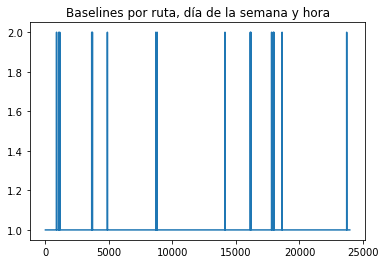

In [26]:
plt.plot(baseline['baseline_people_moving']) 
plt.title("Baselines por ruta, día de la semana y hora")
plt.show()

In [27]:
baseline_inconsistente

ruta dia_semana  hr  \
869        Atizapán de Zaragoza - Iztapalapa    Domingo   0   
870        Atizapán de Zaragoza - Iztapalapa    Domingo   8   
875        Atizapán de Zaragoza - Iztapalapa      Lunes   0   
876        Atizapán de Zaragoza - Iztapalapa      Lunes   8   
877        Atizapán de Zaragoza - Iztapalapa      Lunes  16   
1043          Atizapán de Zaragoza - Tlalpan    Domingo   0   
1045          Atizapán de Zaragoza - Tlalpan    Domingo  16   
1049          Atizapán de Zaragoza - Tlalpan      Lunes   8   
1050          Atizapán de Zaragoza - Tlalpan      Lunes  16   
1127   Atizapán de Zaragoza - Álvaro Obregón    Domingo   0   
1128   Atizapán de Zaragoza - Álvaro Obregón    Domingo   8   
1129   Atizapán de Zaragoza - Álvaro Obregón    Domingo  16   
3643                   Chicoloapan - Tlalpan      Lunes   8   
3644                   Chicoloapan - Tlalpan      Lunes  16   
3695            Chicoloapan - Álvaro Obregón    Domingo  16   
3698            Chicoloapan - Álvaro Obregón      Lunes   0   
3699            Chicoloapan - Álvaro Obregón      Lunes   8   
3700            Chicoloapan - Álvaro Obregón      Lunes  16   
4877                 Cocotitlán - Iztapalapa      Lunes   0   
4878                 Cocotitlán - Iztapalapa      Lunes   8   
8687           Ecatepec de Morelos - Tlalpan    Domingo   0   
8688           Ecatepec de Morelos - Tlalpan    Domingo   8   
8689           Ecatepec de Morelos - Tlalpan    Domingo  16   
8794        Ecatepec de Morelos - Xochimilco    Domingo  16   
8796        Ecatepec de Morelos - Xochimilco      Lunes   0   
14135            Milpa Alta - Álvaro Obregón      Lunes  16   
16127                 Ocoyoacac - Iztapalapa      Lunes   0   
16166                    Ocoyoacac - Tlalpan      Lunes   0   
16174             Ocoyoacac - Álvaro Obregón    Domingo   0   
16178             Ocoyoacac - Álvaro Obregón      Lunes   0   
17804               Tepotzotlán - Iztapalapa      Lunes   0   
17935                  Tepotzotlán - Tlalpan      Lunes   0   
17983           Tepotzotlán - Álvaro Obregón      Lunes   0   
18630               Tlalmanalco - Iztapalapa      Lunes   0   
23714            Álvaro Obregón - Milpa Alta    Domingo   0   

       baseline_people_moving  
869                         2  
870                         2  
875                         2  
876                         2  
877                         2  
1043                        2  
1045                        2  
1049                        2  
1050                        2  
1127                        2  
1128                        2  
1129                        2  
3643                        2  
3644                        2  
3695                        2  
3698                        2  
3699                        2  
3700                        2  
4877                        2  
4878                        2  
8687                        2  
8688                        2  
8689                        2  
8794                        2  
8796                        2  
14135                       2  
16127                       2  
16166                       2  
16174                       2  
16178                       2  
17804                       2  
17935                       2  
17983                       2  
18630                       2  
23714                       2

In [28]:
data[(data['starting_region_name']=='Atizapán de Zaragoza') & (data['ending_region_name']=='Iztapalapa') 
          & (data['hr']==0) & (data['dia_semana']=='Domingo')].sort_values(['fecha','hr'])

difference  baseline_people_moving  crisis_people_moving  \
10378          0.6                    14.4                    15   
49943         -2.4                    14.4                    12   
131691     -3105.2                  5975.2                  2870   

        starting_region_name  percent_change ending_region_name  length_km  \
10378   Atizapán de Zaragoza        3.896104         Iztapalapa  27.100748   
49943   Atizapán de Zaragoza      -15.584416         Iztapalapa  25.916037   
131691  Atizapán de Zaragoza      -51.959439         Iztapalapa  26.060411   

        hr      fecha ori_cdmx des_cdmx  num_semana dia_semana  \
10378    0 2020-03-01     Otro     CDMX           9    Domingo   
49943    0 2020-03-15     Otro     CDMX          11    Domingo   
131691   0 2020-04-05     Otro     CDMX          14    Domingo   

                                     ruta  
10378   Atizapán de Zaragoza - Iztapalapa  
49943   Atizapán de Zaragoza - Iztapalapa  
131691  Atizapán de Zaragoza - Iztapalapa

In [29]:
original_data[(original_data['starting_region_name']=='Atizapán de Zaragoza') & (original_data['ending_region_name']=='Iztapalapa') 
          & (original_data['fecha']=='2020-04-05') & (original_data['hr']==0)]
# Otros domingos
# 2020-03-01 , 2020-04-05 

difference  baseline_people_moving  crisis_people_moving  \
131691     -3105.2                  5975.2                  2870   
131694     -3105.2                  5975.2                  2870   
131697     -3105.2                  5975.2                  2870   

        percent_change  standard_z_score  starting_region_name  \
131691      -51.959439         -2.503942  Atizapán de Zaragoza   
131694      -51.959439         -2.503942  Atizapán de Zaragoza   
131697      -51.959439         -2.503942  Atizapán de Zaragoza   

       ending_region_name  starting_location  ending_location  length_km  \
131691         Iztapalapa             591219           589187  26.060411   
131694         Iztapalapa             591219           589187  26.060411   
131697         Iztapalapa             591219           589187  26.060411   

                                                 geometry  start_lat  \
131691  LINESTRING (-99.228515625 19.55976887025072, -...        NaN   
131694  LINESTRING (-99.228515625 19.55976887025072, -...        NaN   
131697  LINESTRING (-99.228515625 19.55976887025072, -...        NaN   

        start_lon  end_lat  end_lon      hora  hr      fecha  
131691        NaN      NaN      NaN  00:00:00   0 2020-04-05  
131694        NaN      NaN      NaN  00:00:00   0 2020-04-05  
131697        NaN      NaN      NaN  00:00:00   0 2020-04-05

In [30]:
baseline_inconsistente = baseline_inconsistente['ruta']

# 3. Rutas

Las rutas con origen y destino fuera de la CDMX representan el 40% de las rutas en la base, mientras que las que tienen origen y destino en la CDMX son el 23.7%.

La distribución de las rutas por hora, según su origen destino, se mantiene casi constante a lo largo de las 3 ventanas de tiempo para las rutas con origen y destino fuera de la CDMX.

Para las rutas con origen y destino en la CDMX, también se mantuvieron relativamente constantes a lo largo del día.

Las rutas con origen fuera de la CDMX y destino en la CDMX concentraron el 22% y 20% a las 8 y 16 horas, pero disminuyeron hasta 14% para las 00 horas. Inversamente, las rutas con origen en la CDMX y destino fuera de la CDMX aumentaron a 23% a las 00 horas, de 13% y 16% a las 8 y 6 horas.


In [31]:
total_rutas = len(data)
rutas = data.groupby(['ori_cdmx', 'des_cdmx']).size()
rutas = rutas.reset_index()  
rutas.columns = ['Origen', 'Destino', 'Rutas']
rutas = rutas.pivot_table(index='Origen', columns='Destino', values='Rutas')
rutas_prop = rutas.divide(total_rutas) * 100

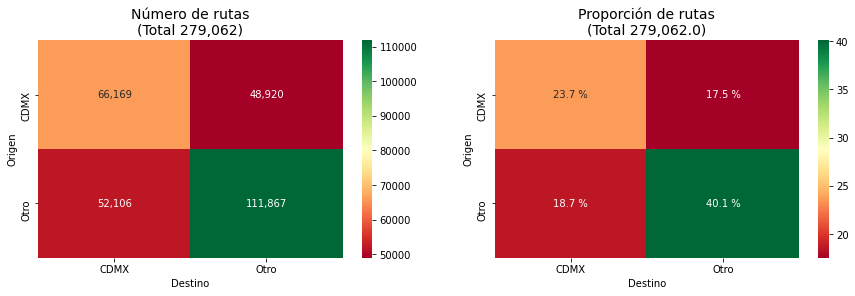

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.heatmap( rutas, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('Número de rutas\n(Total {:0,.0f})'.format(total_rutas), fontsize=14)

sns.heatmap( rutas_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('Proporción de rutas\n(Total {:0,.1f})'.format(total_rutas), fontsize=14)
for t in ax[1].texts: t.set_text(t.get_text() + " %")


plt.show()

In [33]:
ruta_hora = data.groupby(['ori_cdmx', 'des_cdmx', 'hr']).size()
ruta_hora = ruta_hora.reset_index()  
ruta_hora.columns = ['Origen', 'Destino', 'hr', 'Rutas']

ruta0 = ruta_hora[ruta_hora['hr']==0].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta8 = ruta_hora[ruta_hora['hr']==8].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta16 = ruta_hora[ruta_hora['hr']==16].pivot_table(index='Origen', columns='Destino', values='Rutas')

ruta0_prop = ruta0.divide(ruta0.values.sum())*100
ruta8_prop = ruta8.divide(ruta8.values.sum())*100
ruta16_prop = ruta16.divide(ruta16.values.sum())*100

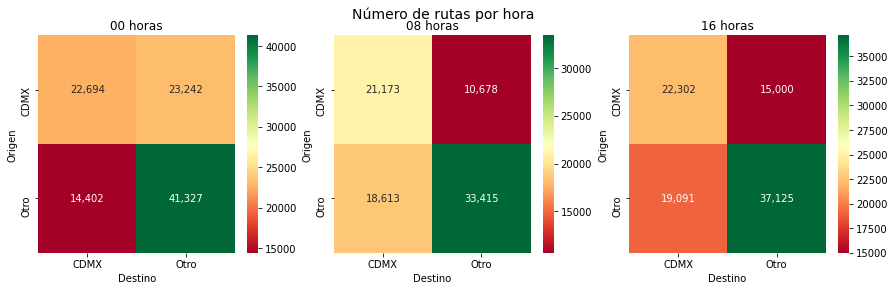

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')

sns.heatmap( ruta8, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
#ax[1].set_yticklabels(())
#ax[1].set_ylabel("")

sns.heatmap( ruta16, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
#ax[2].set_yticklabels(())
#ax[2].set_ylabel("")

fig.suptitle('Número de rutas por hora', fontsize=14)
plt.show()
#plt.tight_layout()


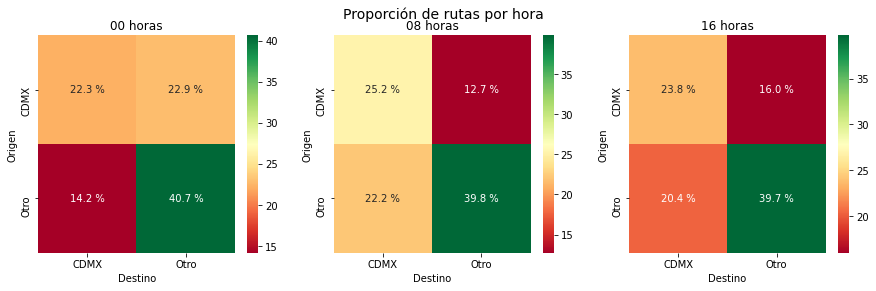

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')
for t in ax[0].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta8_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
for t in ax[1].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta16_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
for t in ax[2].texts: t.set_text(t.get_text() + " %")

fig.suptitle('Proporción de rutas por hora', fontsize=14)
plt.show()
#plt.tight_layout()

## 3.1 Rutas únicas

Existen 1,571 rutas únicas en la base. 

Considerando las ventanas de tiempo, hay 1,438 ruta únicas a las 00 horas, 1,206 a las 08 horas y 1,316 las 16 horas.

In [36]:
print("Existen {:,.0f} rutas únicas". format(len(data['ruta'].unique())))

Existen 1,571 rutas únicas


In [37]:
print("{:,.0f} rutas unicas a las 00 horas".format(len(data[data['hr']==0]['ruta'].unique())))
print("{:,.0f} rutas unicas a las 08 horas".format(len(data[data['hr']==8]['ruta'].unique())))
print("{:,.0f} rutas unicas a las 16 horas".format(len(data[data['hr']==16]['ruta'].unique())))

1,438 rutas unicas a las 00 horas
1,206 rutas unicas a las 08 horas
1,316 rutas unicas a las 16 horas


## 3.2 Distribución de rutas


In [38]:
x = data.groupby(['ruta']).size().sort_values(ascending=False)

In [39]:
bins = [0, 10, 20, 50, 100, 150, 200, 250, 300, 350]
x.groupby(pd.cut(x, bins, right = False)).count()

[0, 10)       191
[10, 20)       51
[20, 50)      133
[50, 100)     190
[100, 150)    106
[150, 200)    108
[200, 250)    111
[250, 300)    169
[300, 350)    512
dtype: int64

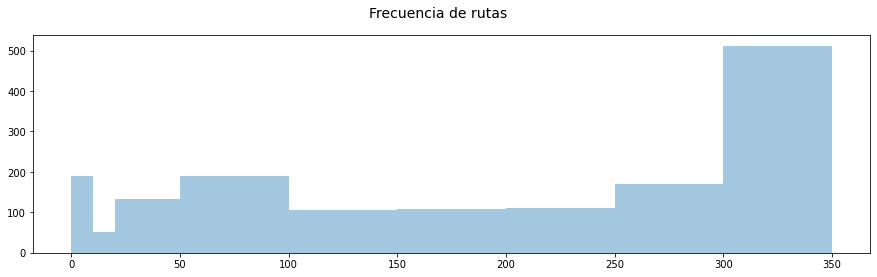

In [40]:
fig, ax = plt.subplots( figsize=(15, 4))
ax = sns.distplot(x, bins, kde=False)
fig.suptitle('Frecuencia de rutas', fontsize=14)
plt.show()

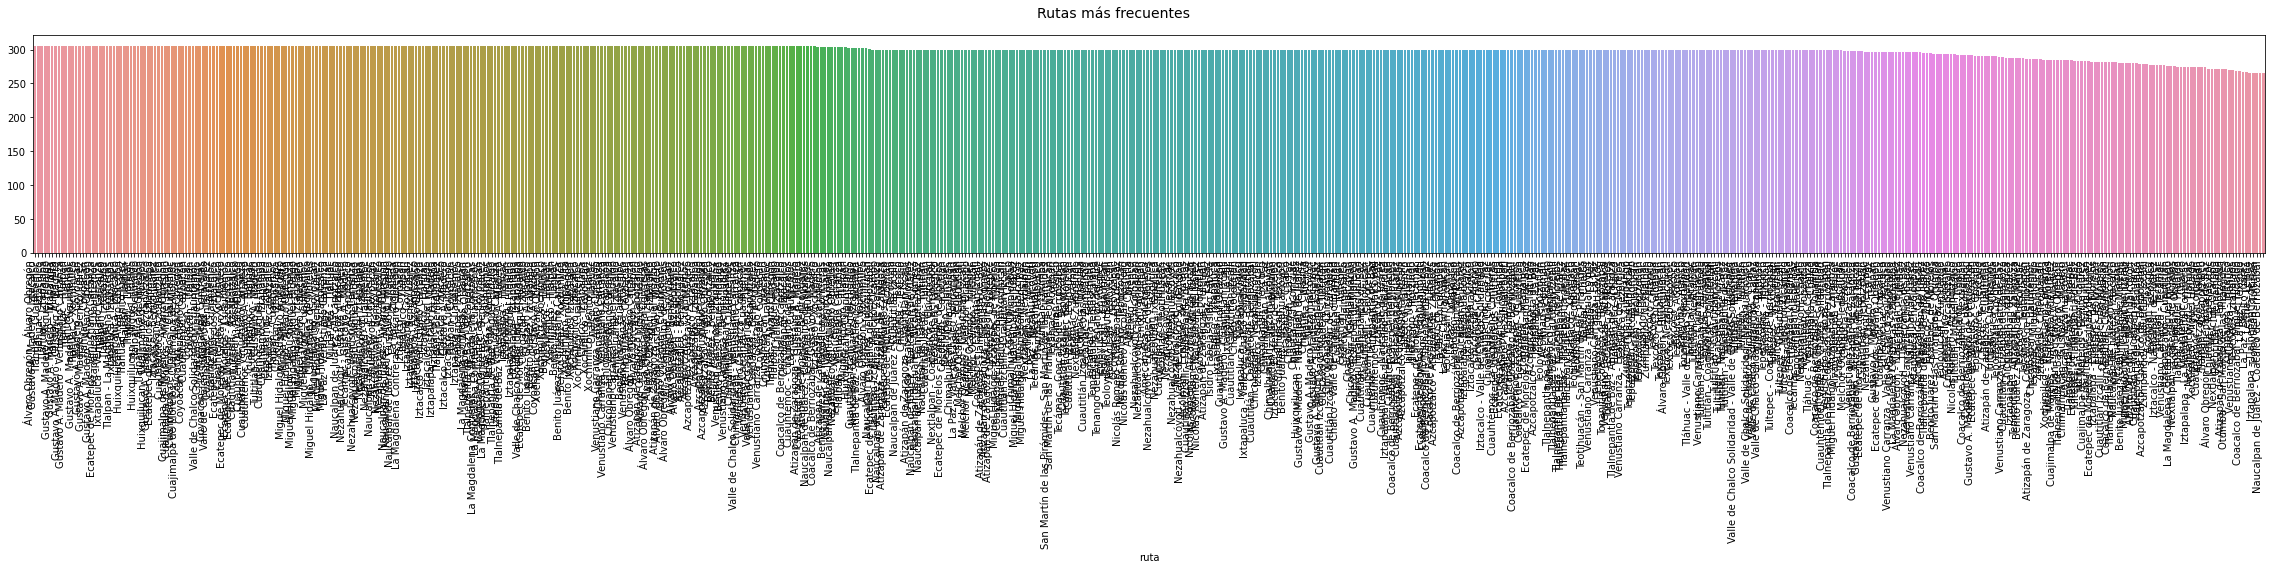

In [41]:
x = x.head(650)

fig, ax = plt.subplots(figsize=(40, 4))

ax = sns.barplot(x=x.index, y=x)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
fig.suptitle('Rutas más frecuentes', fontsize=14)

plt.show()

# 4. Número de personas transitando las rutas

En términos del número de personas que transitan las rutas el 95% se reparte entre rutas con origen y destino en la CDMX y, rutas con origen y destino fuera de la CDMX. El restante 5% de las personas que transitan, lo hace de municipios fuera de la CDMX a las alcaldías de la CDMX o viceversa.

In [42]:
ruta_hora = data.groupby(['ori_cdmx', 'des_cdmx', 'hr']).sum()['crisis_people_moving']
ruta_hora = ruta_hora.reset_index()  
ruta_hora.columns = ['Origen', 'Destino', 'hr', 'Rutas']

ruta0 = ruta_hora[ruta_hora['hr']==0].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta8 = ruta_hora[ruta_hora['hr']==8].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta16 = ruta_hora[ruta_hora['hr']==16].pivot_table(index='Origen', columns='Destino', values='Rutas')

ruta0_prop = ruta0.divide(ruta0.values.sum())*100
ruta8_prop = ruta8.divide(ruta8.values.sum())*100
ruta16_prop = ruta16.divide(ruta16.values.sum())*100

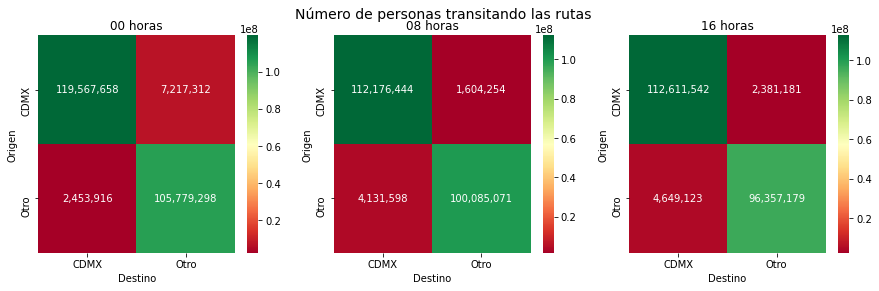

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

sns.heatmap( ruta0, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')

sns.heatmap( ruta8, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')

sns.heatmap( ruta16, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')

fig.suptitle('Número de personas transitando las rutas',fontsize=14)
plt.show()

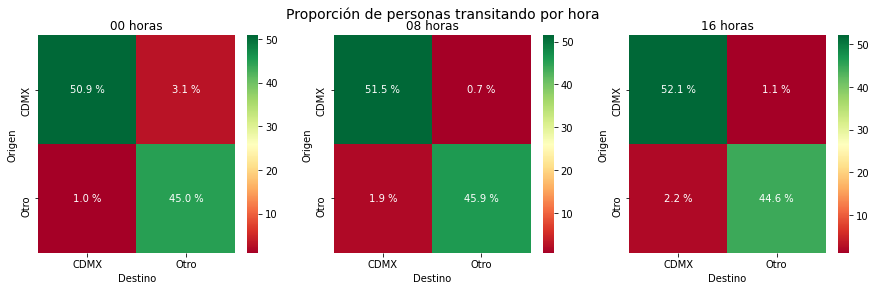

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')
for t in ax[0].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta8_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
for t in ax[1].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta16_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
for t in ax[2].texts: t.set_text(t.get_text() + " %")

fig.suptitle('Proporción de personas transitando por hora', fontsize=14)
plt.show()

## 4.1 Las 100 rutas más transitadas 

Las 100 rutas más transitadas durante la “crisis” transportaron al 92% de las personas que  se movieron. Las principales rutas, nuevamente, se encontraron dentro de la CDMX y entre municipios fuera de la CDMX.

Las 100 rutas más transitadas a lo largo del periodo y aún durante la "crisis", se presentan a continuación.

In [45]:
top_100 = data.groupby(['ruta']).sum()[['baseline_people_moving','crisis_people_moving']].sort_values(['crisis_people_moving'], ascending=False)[:100]

In [46]:
top_100.round(0).style.format('{:,}')

In [47]:
# 100 rutas mas transitadas
top100_rutas = pd.Series(top_100.index)

#top100_rutas

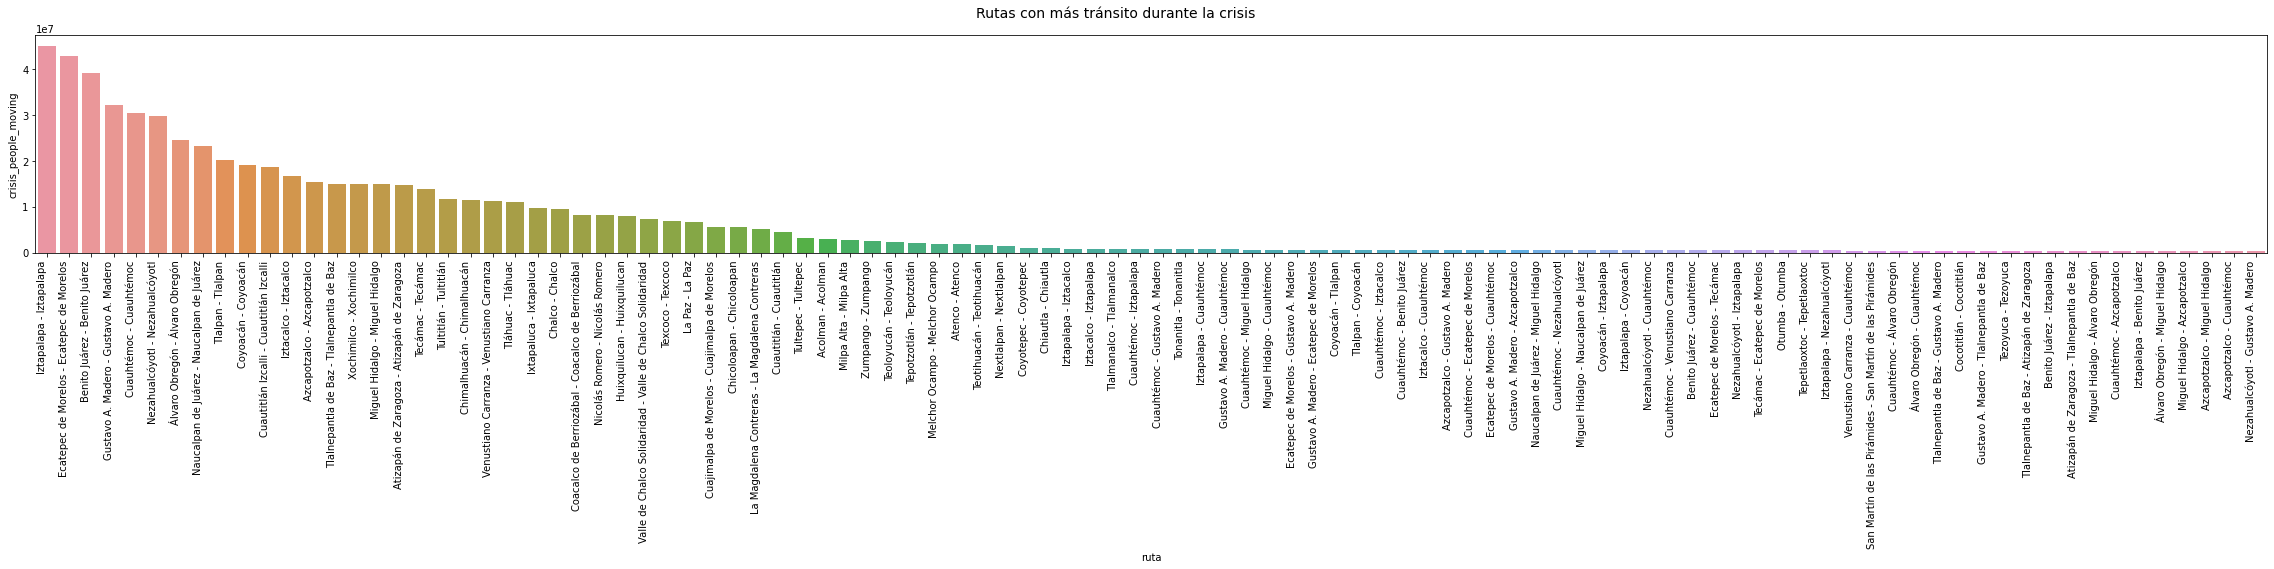

In [48]:
fig, ax = plt.subplots(figsize=(40, 4))

ax = sns.barplot(x=top_100.index, y=top_100['crisis_people_moving'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
fig.suptitle('Rutas con más tránsito durante la crisis', fontsize=14)
plt.show()

In [49]:
top_100['crisis_people_moving'].sum()/data['crisis_people_moving'].sum()

0.9187964403932508

In [50]:
# Origen - Destino de las 100 rutas más transitadas durante la "crisis"
ori_des = pd.DataFrame(top_100.index.str.split(' - ', expand=True).to_list(), columns = ['mun_origen','mun_destino'])
top_100 = top_100.assign(Origen=np.where(ori_des["mun_origen"].isin(delegaciones), 'CDMX', 'Otro'), 
                         Destino=np.where(ori_des["mun_destino"].isin(delegaciones), 'CDMX', 'Otro'))

In [51]:
top_100 = top_100.pivot_table(index='Origen', columns='Destino', values='crisis_people_moving')
top_100 = top_100.divide(top_100.values.sum())*100

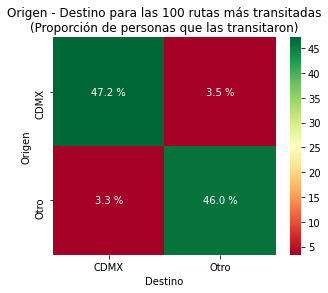

In [52]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap( top_100, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Origen - Destino para las 100 rutas más transitadas\n(Proporción de personas que las transitaron)', fontsize=12)
plt.show()

# 5. Distribución de las longitudes de las rutas

El 76% de las rutas consideradas tuvieron una longitud menor a 20 km.

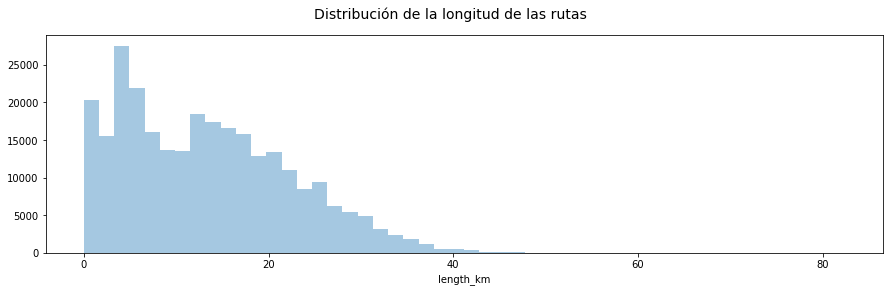

In [53]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.distplot(data['length_km'], kde=False)
fig.suptitle('Distribución de la longitud de las rutas', fontsize=14)
plt.show()

In [54]:
# Porcentaje de rutas con longitud menor o igual a 20 km
(data[data['length_km']<=20]['length_km'].count()/len(data))*100

75.82006865857767

# 6. Rutas constantes

## 6.1 Usando el baseline original

Tomamos como baseline el original de la base.

In [55]:
df_cambio = data[['ruta', 'fecha', 'percent_change']].groupby(['ruta', 'fecha']).mean().unstack()

In [56]:
# Anado columnas para indicar si el Origen/Destino esta o no en la CDMX
ori_des = pd.DataFrame(df_cambio.index.str.split(' - ', expand=True).to_list(), columns = ['mun_origen','mun_destino'])
df_cambio = df_cambio.assign(Origen=np.where(ori_des["mun_origen"].isin(delegaciones), 'CDMX', 'Otro'), 
                             Destino=np.where(ori_des["mun_destino"].isin(delegaciones), 'CDMX', 'Otro'))

In [57]:
# Anado columna para indicar si la ruta esta en las 100 mas transitadas
df_cambio = df_cambio.assign(Top100=np.where(df_cambio.index.isin(top100_rutas), 1, 0))

In [58]:
# Anado columna para media antes y despues del 23 de marzo
last_col = len(df_cambio.columns) - 3
df_cambio['mean_antes_23032020'] = df_cambio.iloc[:,:26].mean(axis=1, skipna=True)
df_cambio['mean_despues_23032020'] = df_cambio.iloc[:,26:last_col].mean(axis=1, skipna=True)

df_cambio['mean_antes_16032020'] = df_cambio.iloc[:,:19].mean(axis=1, skipna=True)
df_cambio['mean_despues_16032020'] = df_cambio.iloc[:,26:last_col].mean(axis=1, skipna=True)

### a) Rutas CDMX -> CDMX

Tenemos 248 rutas con origen y destino en alguna alcaldía de la CDMX.

In [59]:
cdmx_cdmx = df_cambio.loc[(df_cambio['Origen']=='CDMX') & (df_cambio['Destino']=='CDMX')].copy()
cdmx_cdmx.drop(['Origen', 'Destino', 'Top100', 'mean_antes_23032020', 'mean_despues_23032020', 'mean_antes_16032020', 'mean_despues_16032020'], axis=1, inplace=True)

In [60]:
cdmx_cdmx.shape

(248, 102)

In [61]:
#cdmx_cdmx.loc['Azcapotzalco - Azcapotzalco'].describe()
cdmx_cdmx

percent_change                        \
fecha                                    2020-02-27 2020-02-28 2020-02-29   
ruta                                                                        
Azcapotzalco - Azcapotzalco               -1.119351  -0.408796  -0.874779   
Azcapotzalco - Benito Juárez               2.186757   1.592461   2.449174   
Azcapotzalco - Coyoacán                    1.184799  -3.034896   8.993952   
Azcapotzalco - Cuajimalpa de Morelos      -0.933360  -9.070277  21.192526   
Azcapotzalco - Cuauhtémoc                  0.505516   0.516408   4.007752   
...                                             ...        ...        ...   
Álvaro Obregón - Tlalpan                  -2.518683  -2.064073  -5.596212   
Álvaro Obregón - Tláhuac                  -1.381560  -5.182746   6.620538   
Álvaro Obregón - Venustiano Carranza      -3.174208   2.643297  -6.461919   
Álvaro Obregón - Xochimilco               -5.291734  -3.490339  -2.161605   
Álvaro Obregón - Álvaro Obregón           -0.819693  -0.494139  -1.215770   

                                                                       \
fecha                                2020-03-01 2020-03-02 2020-03-03   
ruta                                                                    
Azcapotzalco - Azcapotzalco           -0.979440  -0.352949  -1.146269   
Azcapotzalco - Benito Juárez          -5.551885  11.026357   3.337887   
Azcapotzalco - Coyoacán                4.640378   4.690613   6.717087   
Azcapotzalco - Cuajimalpa de Morelos  17.356414   1.055152  -1.860167   
Azcapotzalco - Cuauhtémoc             -2.995604   9.182725   3.465365   
...                                         ...        ...        ...   
Álvaro Obregón - Tlalpan               1.938885   0.709897   2.692177   
Álvaro Obregón - Tláhuac               4.071384  16.907907  11.762261   
Álvaro Obregón - Venustiano Carranza   0.923362  -0.291832   5.455269   
Álvaro Obregón - Xochimilco           19.410515  -5.672272   5.156852   
Álvaro Obregón - Álvaro Obregón       -0.682700   0.160715  -0.359693   

                                                                       \
fecha                                2020-03-04 2020-03-05 2020-03-06   
ruta                                                                    
Azcapotzalco - Azcapotzalco           -0.329203  -0.456520  -0.870266   
Azcapotzalco - Benito Juárez           1.919253   1.317425   3.160315   
Azcapotzalco - Coyoacán              -13.613142  -7.117432  -6.748005   
Azcapotzalco - Cuajimalpa de Morelos  -6.165623   0.281870   1.654730   
Azcapotzalco - Cuauhtémoc             -0.888152  -0.634609   0.801903   
...                                         ...        ...        ...   
Álvaro Obregón - Tlalpan              -0.961508  -1.847031  -2.849483   
Álvaro Obregón - Tláhuac               1.246449  -2.269948  -3.094016   
Álvaro Obregón - Venustiano Carranza   0.291049  -3.489509  -2.509754   
Álvaro Obregón - Xochimilco           -5.919536  -5.921210  -0.645065   
Álvaro Obregón - Álvaro Obregón       -0.261757  -0.393720  -0.627362   

                                                 ...                        \
fecha                                2020-03-07  ... 2020-05-29 2020-05-30   
ruta                                             ...                         
Azcapotzalco - Azcapotzalco           -0.692525  ...  18.745540  14.536792   
Azcapotzalco - Benito Juárez          -1.155890  ... -74.065792 -62.926252   
Azcapotzalco - Coyoacán               -7.665324  ... -78.786981 -77.000366   
Azcapotzalco - Cuajimalpa de Morelos   0.782671  ... -85.556911 -61.408802   
Azcapotzalco - Cuauhtémoc             -3.644182  ... -69.037302 -65.783861   
...                                         ...  ...        ...        ...   
Álvaro Obregón - Tlalpan               6.543735  ... -69.643591 -67.959058   
Álvaro Obregón - Tláhuac              15.568294  ... -66.468191 -56.101649   
Álvaro Obregón - Venustiano Carranza   9.407454  ... -

In [62]:
cdmx_cdmx.loc['Azcapotzalco - Azcapotzalco', ('percent_change',)]

fecha
2020-02-27    -1.119351
2020-02-28    -0.408796
2020-02-29    -0.874779
2020-03-01    -0.979440
2020-03-02    -0.352949
                ...    
2020-06-03    19.023790
2020-06-04    18.232735
2020-06-05    17.623094
2020-06-06    13.888436
2020-06-07    11.361597
Name: Azcapotzalco - Azcapotzalco, Length: 102, dtype: float64

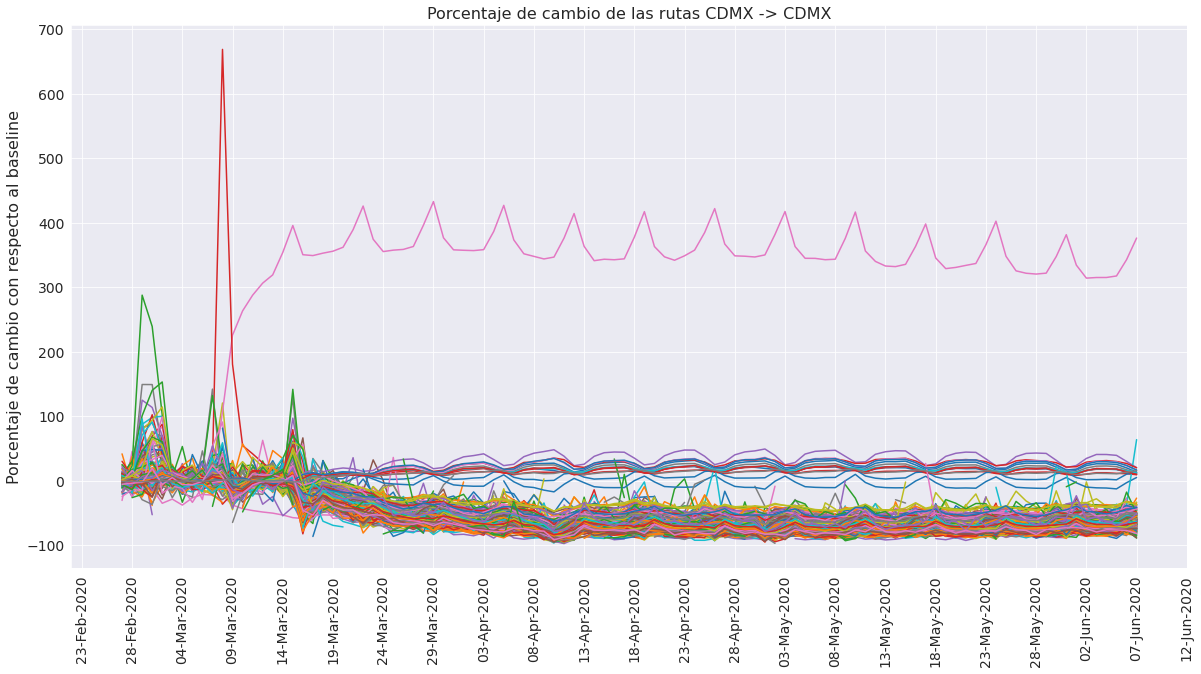

In [63]:
rutas = cdmx_cdmx.index
dias = cdmx_cdmx.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas: 
    ax.plot(cdmx_cdmx.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()


In [64]:
# Rutas sin 'Benito Juárez - Benito Juárez'
cdmx_cdmx_avg_change = cdmx_cdmx.loc[cdmx_cdmx.index != 'Benito Juárez - Benito Juárez']
cdmx_cdmx_avg_change = cdmx_cdmx_avg_change.mean(axis=1, skipna=True)

In [65]:
cdmx_cdmx_avg_change.describe()

count    247.000000
mean     -44.920996
std       18.562950
min      -67.155991
25%      -56.510508
50%      -49.614906
75%      -41.166508
max       28.197069
dtype: float64

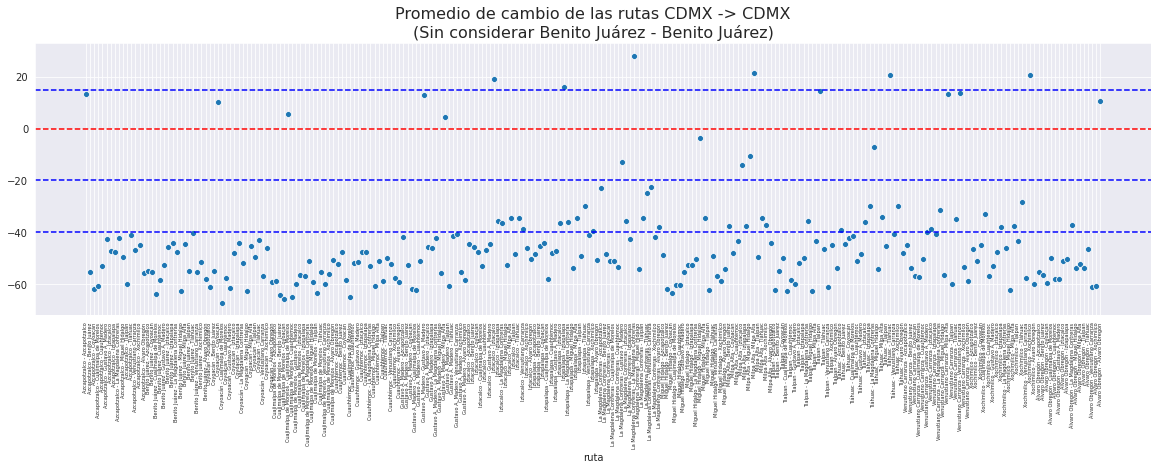

In [66]:
fig, ax = plt.subplots(figsize=(20,5))

ax = sns.scatterplot(x=cdmx_cdmx_avg_change.index, y=cdmx_cdmx_avg_change )
plt.axhline(y=-40, color='blue', linestyle='dashed')
plt.axhline(y=-20, color='blue', linestyle='dashed')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.axhline(y=15, color='blue', linestyle='dashed')

plt.title('Promedio de cambio de las rutas CDMX -> CDMX\n(Sin considerar Benito Juárez - Benito Juárez)', fontsize='16')
plt.xticks(fontsize='5', rotation='vertical')
plt.show()

Podemos dividir las rutas según su promedio de cambio en el periodo, en los siguientes intervalos:

| Grupo | Intevalo | No. Rutas |
|:-----:|:--------:|:---------:|
|Grupo 1|[-100, -40)| 191 |
|Grupo 2|[-40, -20)| 36 |
|Grupo 3|[-20, 0)| 5 |
|Grupo 4|[0, 15)| 9 |
|Grupo 5|[15, 500)| 6 |


El caso de 'Benito Juárez - Benito Juárez' se estudiara por separado.

In [67]:
bins = [-100, -40, -20, 0, 15, 500]
grupos = pd.cut(cdmx_cdmx_avg_change, bins, right = False)

In [68]:
index_grupo1 =  grupos[grupos == grupos.cat.categories[0]].index
grupo1 = cdmx_cdmx.loc[index_grupo1]

index_grupo2 =  grupos[grupos == grupos.cat.categories[1]].index
grupo2 = cdmx_cdmx.loc[index_grupo2]

index_grupo3 =  grupos[grupos == grupos.cat.categories[2]].index
grupo3 = cdmx_cdmx.loc[index_grupo3]

index_grupo4 =  grupos[grupos == grupos.cat.categories[3]].index
grupo4 = cdmx_cdmx.loc[index_grupo4]

index_grupo5 =  grupos[grupos == grupos.cat.categories[4]].index
grupo5 = cdmx_cdmx.loc[index_grupo5]

In [69]:
print("No. group 1: {}\nNo. group 2: {}\nNo. group 3: {}\nNo. group 4: {}\nNo. group 5: {}".format(grupo1.shape[0], 
                                                                                                   grupo2.shape[0],
                                                                                                   grupo3.shape[0],
                                                                                                   grupo4.shape[0],
                                                                                                   grupo5.shape[0]) )

No. group 1: 191
No. group 2: 36
No. group 3: 5
No. group 4: 9
No. group 5: 6


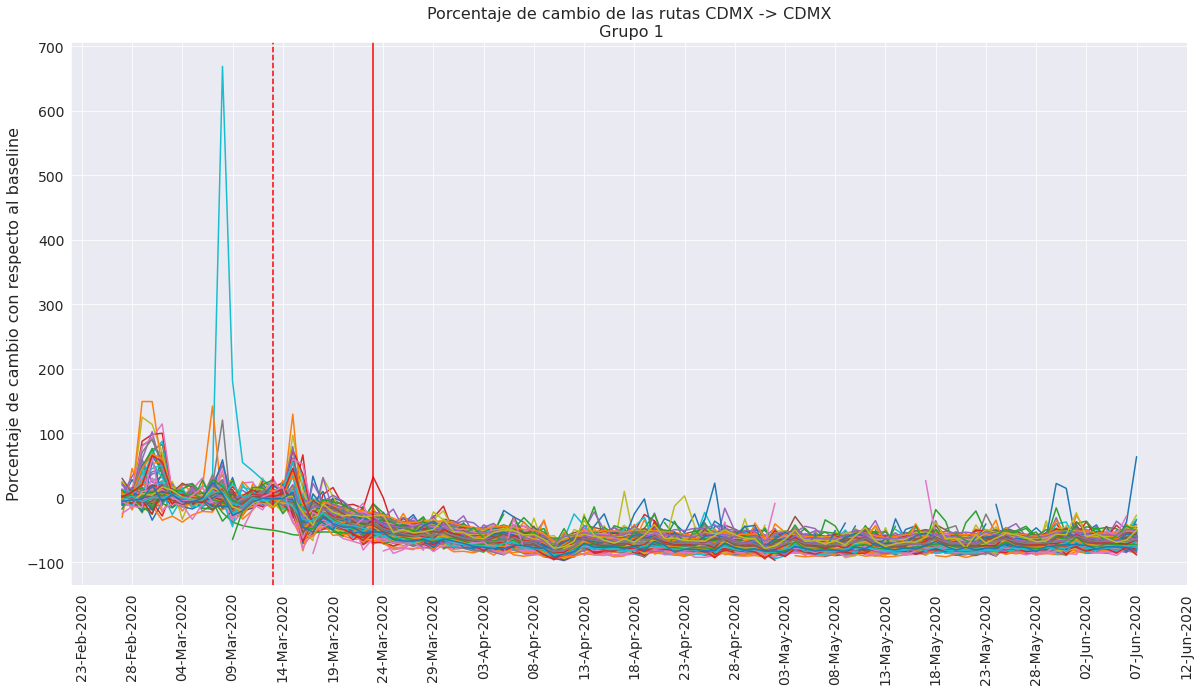

In [70]:
rutas = grupo1.index
dias = grupo1.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo1.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 1', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()


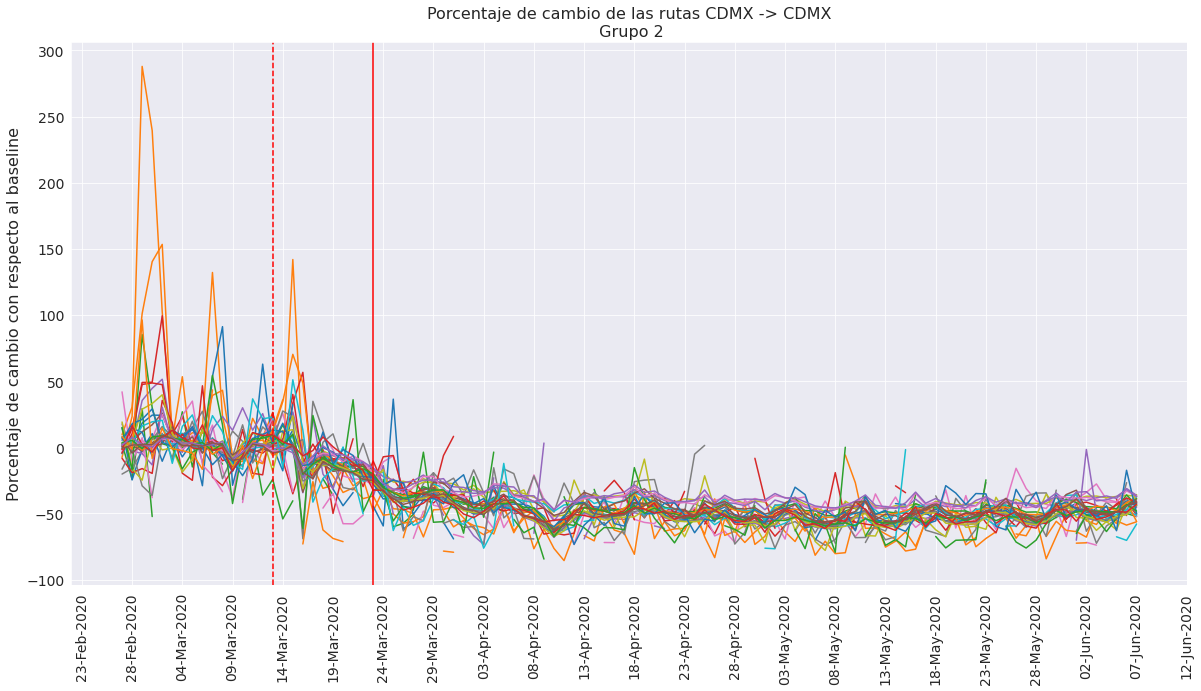

In [71]:
rutas = grupo2.index
dias = grupo2.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo2.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 2', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()


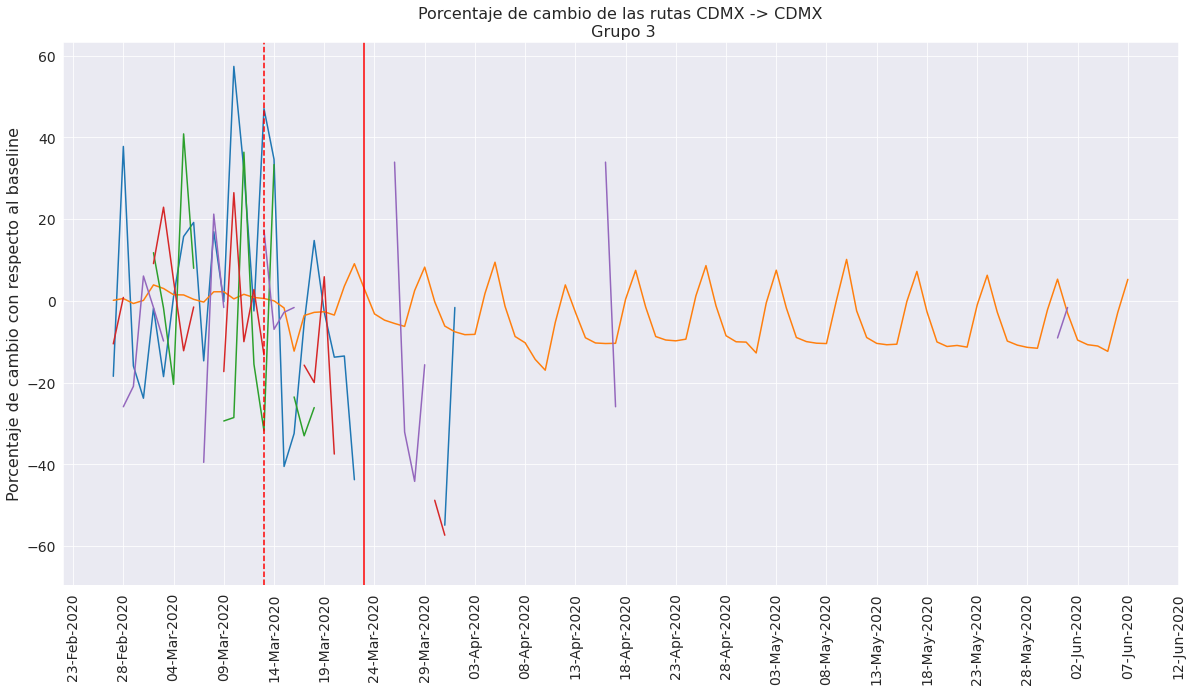

In [72]:
rutas = grupo3.index
dias = grupo3.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo3.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 3', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

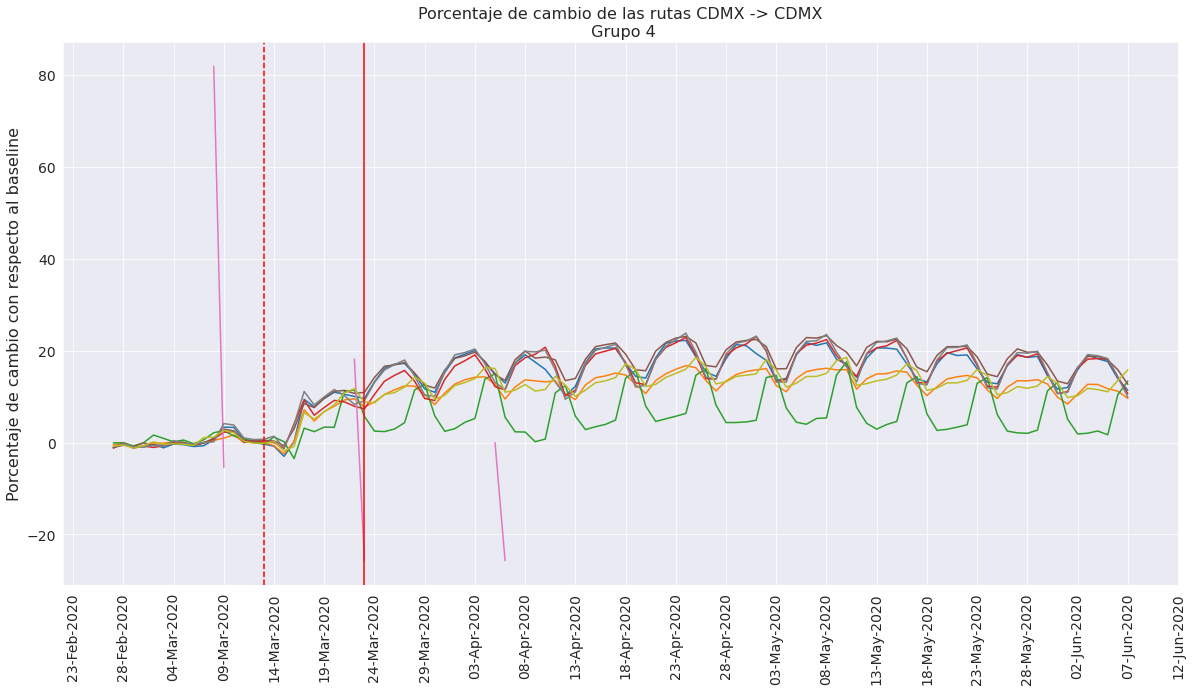

In [73]:
rutas = grupo4.index
dias = grupo4.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo4.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 4', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

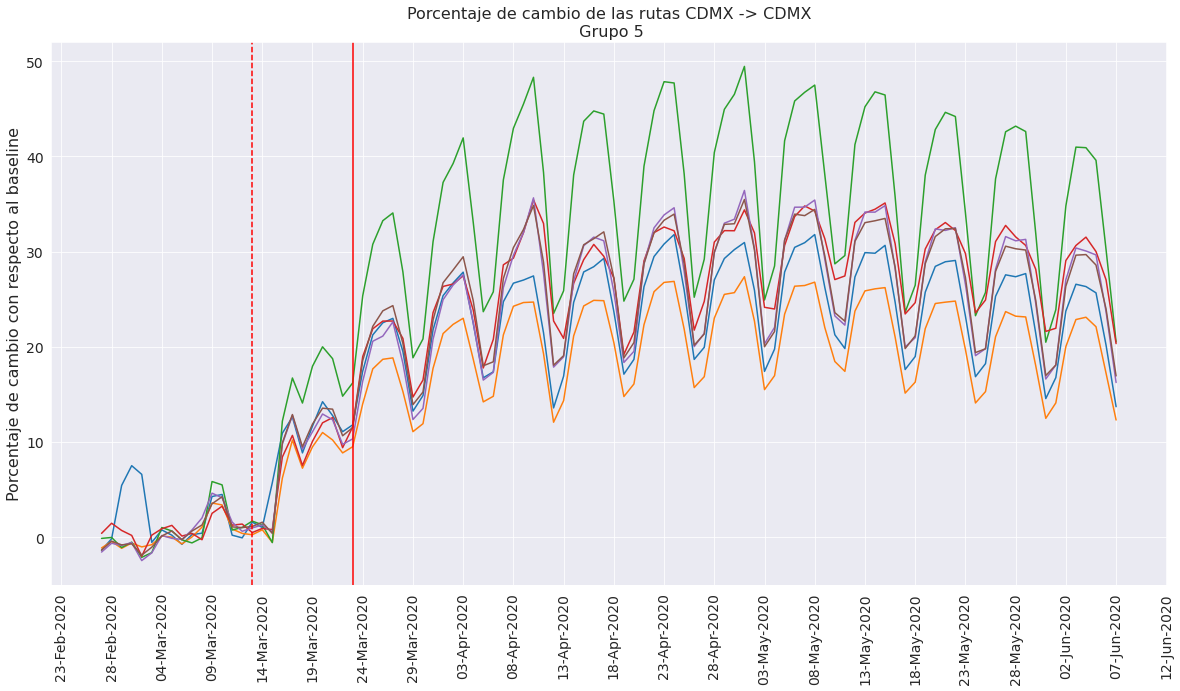

In [74]:
rutas = grupo5.index
dias = grupo5.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo5.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 5', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

### Ruta Benito Juárez - Benito Juárez

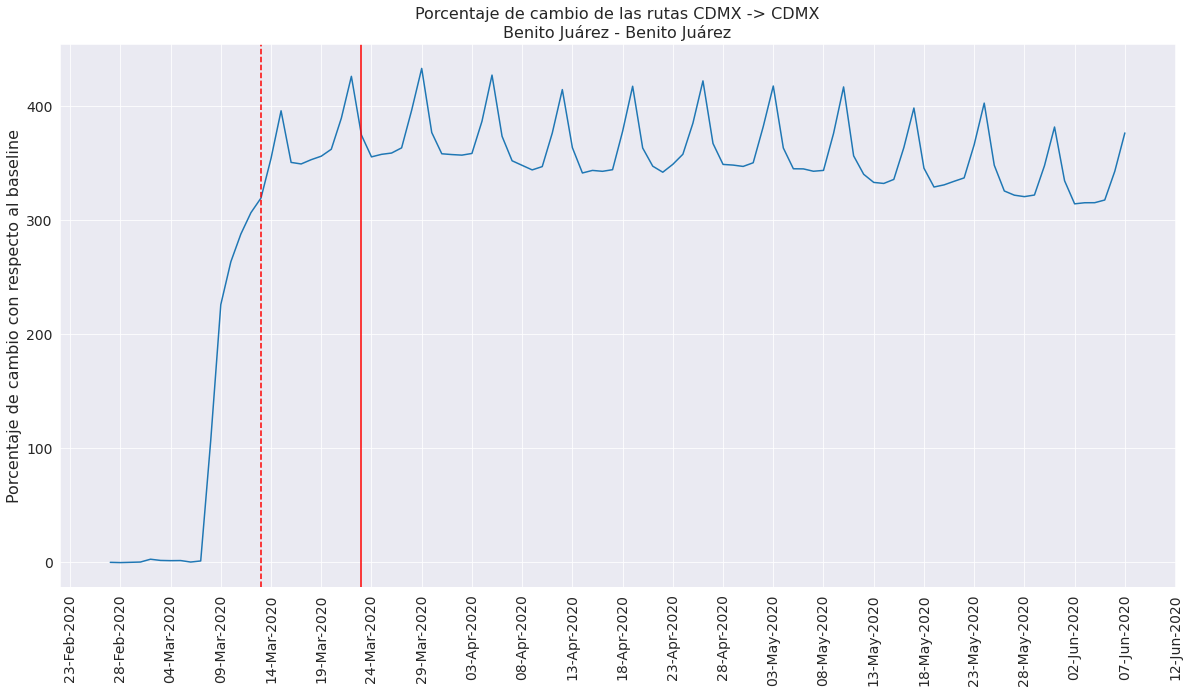

In [75]:
ruta = 'Benito Juárez - Benito Juárez'
rutas = cdmx_cdmx.loc[ruta, ('percent_change',)]
dias = cdmx_cdmx.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(rutas)

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n{}'.format(ruta), fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()



Existen 47 rutas cuyo Origen es Benito Juárez y 42 rucas con Destino en esa misma alcaldia, 89 rutas en total que en promedio todas disminuyeron cerca del 33%.

12 rutas tuvieron, en promedio, un cambio positivo en todo el periodo, las restantes tuvieron un cambio negativo.

In [76]:
ruta_bj = data[(data['starting_region_name']=='Benito Juárez') | (data['ending_region_name']=='Benito Juárez')].groupby(['ruta', 'fecha']).mean()['percent_change'].unstack().mean(axis=1, skipna =True)

print("Promedio % de cambio: ", ruta_bj.mean(axis=0))

Promedio % de cambio:  -33.18575469533561


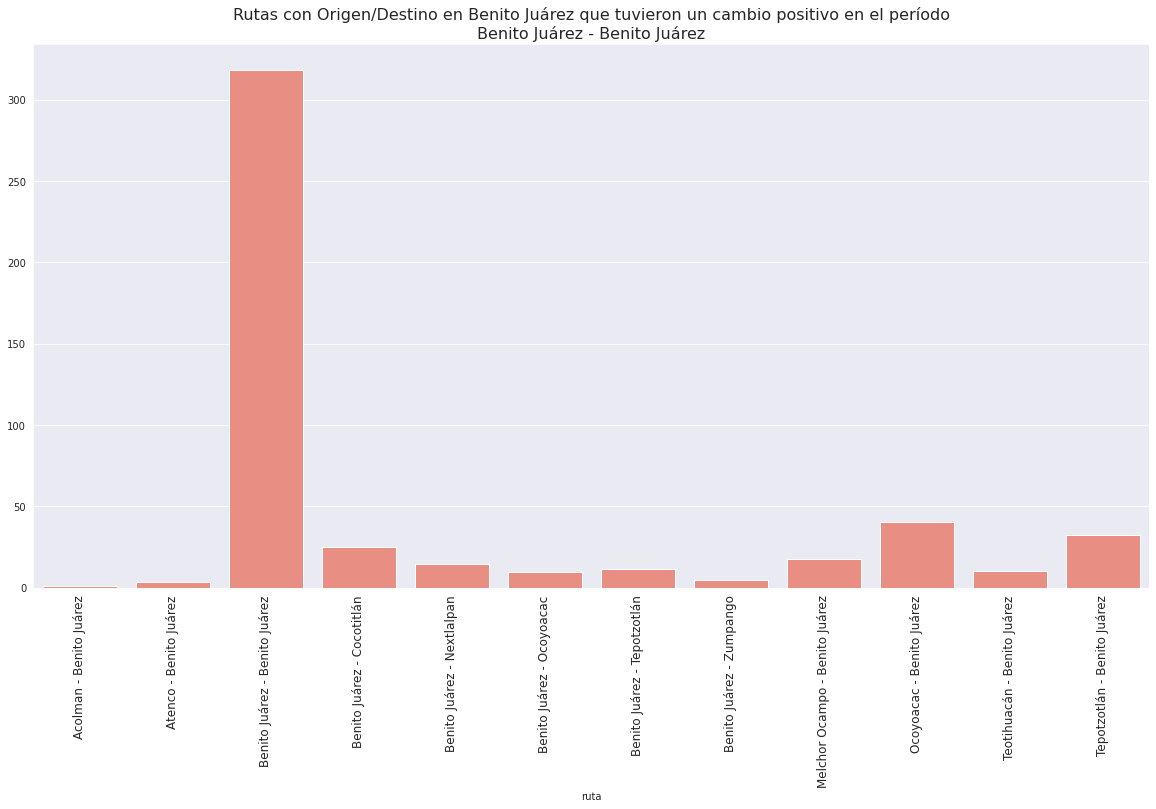

In [77]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot(x=ruta_bj[ruta_bj.values>0].index, y=ruta_bj[ruta_bj.values>0].values, color="salmon")

plt.title('Rutas con Origen/Destino en Benito Juárez que tuvieron un cambio positivo en el período\n{}'.format(ruta), fontsize='16')
plt.xticks(fontsize='12', rotation='vertical')
plt.show()


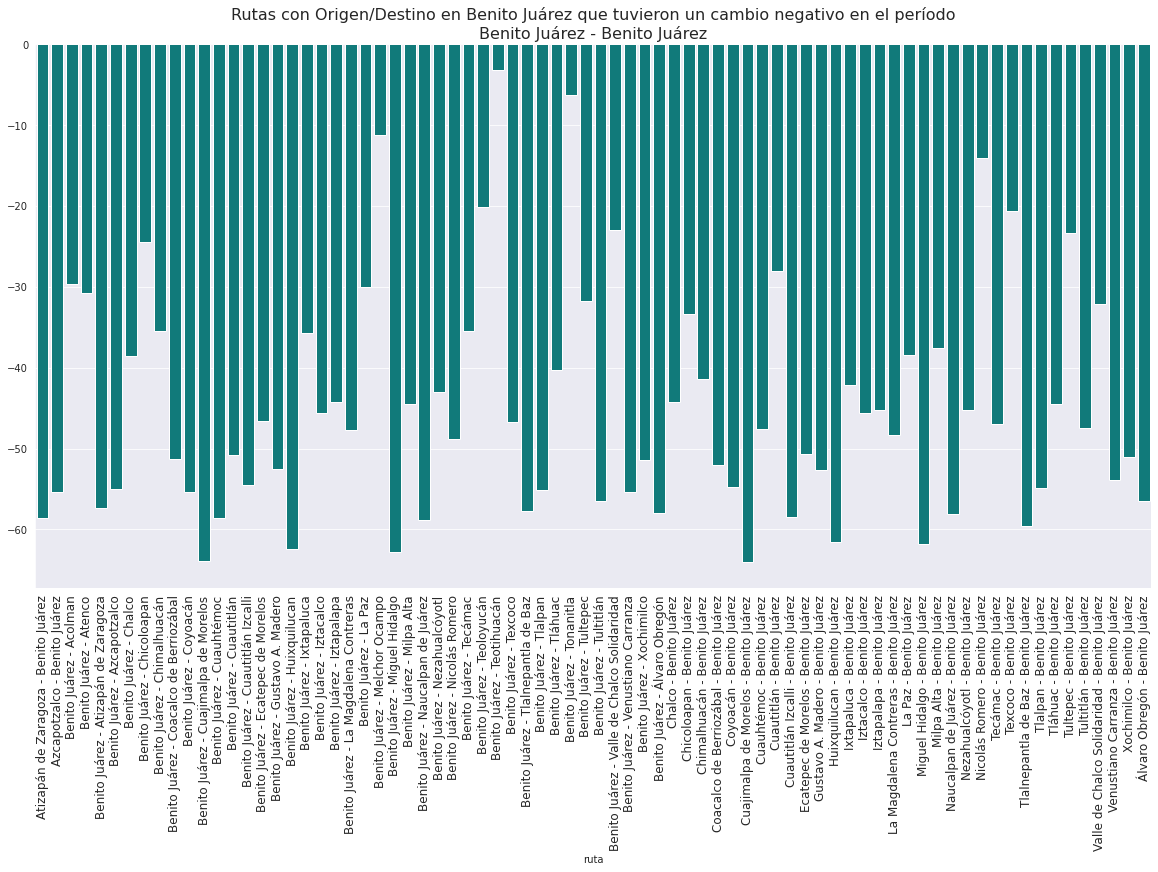

In [78]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot(x=ruta_bj[ruta_bj.values<0].index, y=ruta_bj[ruta_bj.values<0].values, color="darkcyan")

plt.title('Rutas con Origen/Destino en Benito Juárez que tuvieron un cambio negativo en el período\n{}'.format(ruta), fontsize='16')
plt.xticks(fontsize='12', rotation='vertical')
plt.show()

In [79]:
bj = df_cambio[df_cambio.index.str.contains('Benito Juárez')]

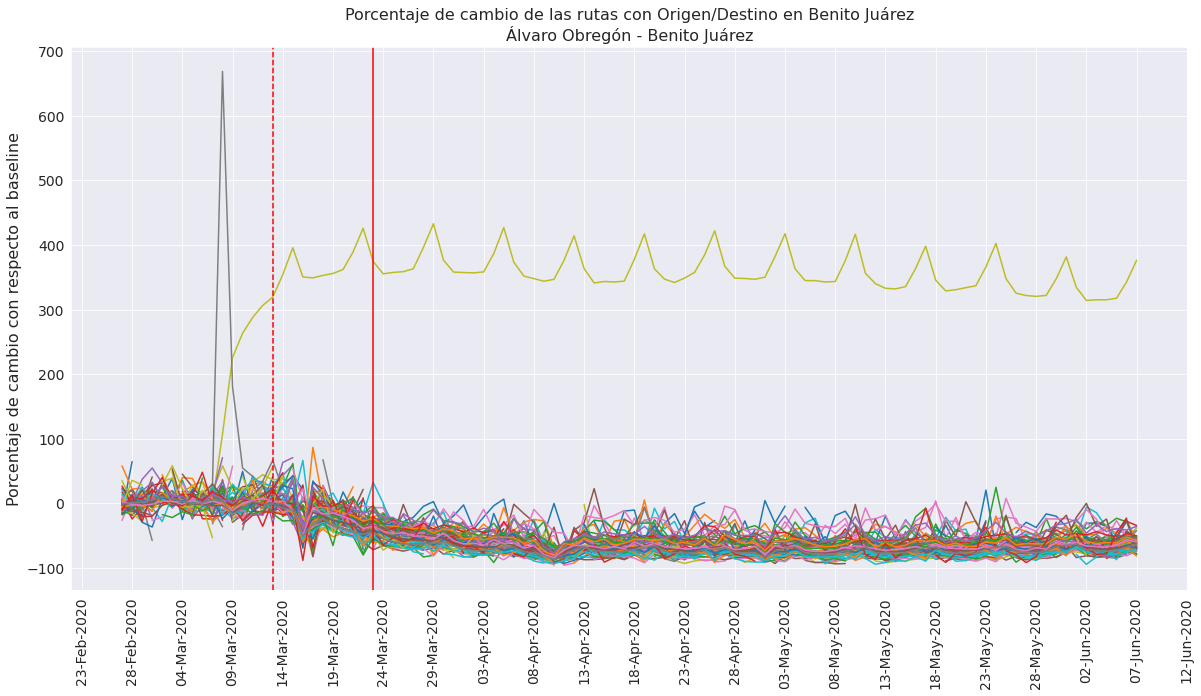

In [80]:
rutas = bj.index
dias = bj.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(bj.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con Origen/Destino en Benito Juárez\n{}'.format(ruta), fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

### b) Baseline antes del 23 de Marzo

Tomando como baseline l

# 7. Rutas que desaparecieron

En 437 de las 1,571 rutas, los valores faltantes superan el 50% del total. Esto podría indicar que las rutas desaparecieron.

In [81]:
# Porcentaje de NaN por ruta
df_nan = df_cambio[('percent_change',)].isnull().mean(axis=1).sort_values(ascending=False)*100

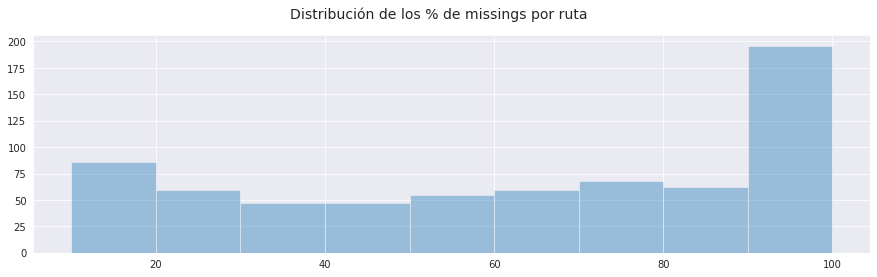

In [82]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.distplot(df_nan, bins=[10,20,30,40,50,60,70,80,90,100], kde=False)
fig.suptitle('Distribución de los % de missings por ruta', fontsize=14)
plt.show()

In [83]:
# Rutas con % de missing values mayores al 50%
rutas_desaparecidas = df_nan[df_nan.values>50]
index_desaparecidas = rutas_desaparecidas.index
print("Rutas con % de nan > 50: ", len(rutas_desaparecidas))

Rutas con % de nan > 50:  437


In [84]:
# Porcentaje de cambio -respecto al baseline- de las rutas con % de missing values mayores al 50%
rutas_des = df_cambio.loc[index_desaparecidas]

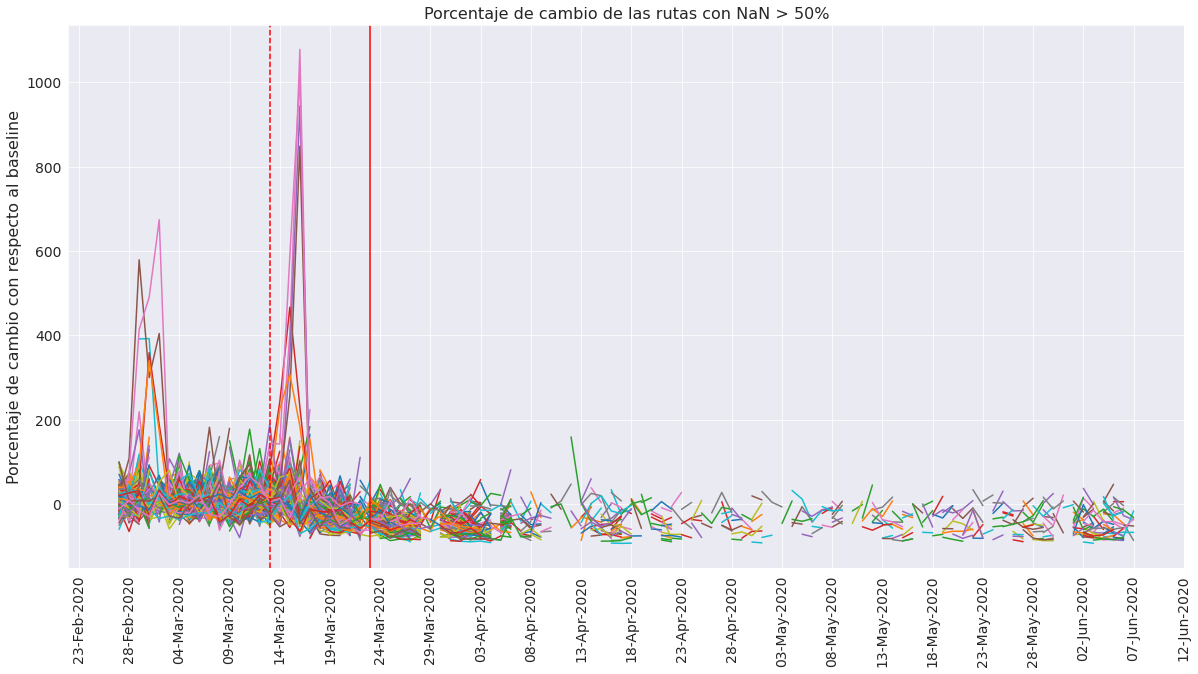

In [85]:
rutas = rutas_des.index
dias =rutas_des.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(rutas_des.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con NaN > 50%', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

Dividimos las rutas por % de NaN:

| Grupo | Intevalo | No. Rutas |
|:-----:|:--------:|:---------:|
|Grupo 1|[50%, 60%)| 52 |
|Grupo 2|[60%, 70%)| 59 |
|Grupo 3|[70%, 80%)| 68 |
|Grupo 4|[80%, 90%)| 62 |
|Grupo 5|[90%, 100)| 196 |

In [86]:
bins = [50, 60, 70, 80, 90, 100]
grupos = pd.cut(rutas_desaparecidas, bins, right = False)

In [87]:
index_grupo1 =  grupos[grupos == grupos.cat.categories[0]].index
grupo1 = rutas_des.loc[index_grupo1]

index_grupo2 =  grupos[grupos == grupos.cat.categories[1]].index
grupo2 = rutas_des.loc[index_grupo2]

index_grupo3 =  grupos[grupos == grupos.cat.categories[2]].index
grupo3 = rutas_des.loc[index_grupo3]

index_grupo4 =  grupos[grupos == grupos.cat.categories[3]].index
grupo4 = rutas_des.loc[index_grupo4]

index_grupo5 =  grupos[grupos == grupos.cat.categories[4]].index
grupo5 = rutas_des.loc[index_grupo5]

In [88]:
print("No. group 1: {}\nNo. group 2: {}\nNo. group 3: {}\nNo. group 4: {}\nNo. group 5: {}".format(grupo1.shape[0], 
                                                                                                   grupo2.shape[0],
                                                                                                   grupo3.shape[0],
                                                                                                   grupo4.shape[0],
                                                                                                   grupo5.shape[0]) )

No. group 1: 52
No. group 2: 59
No. group 3: 68
No. group 4: 62
No. group 5: 196


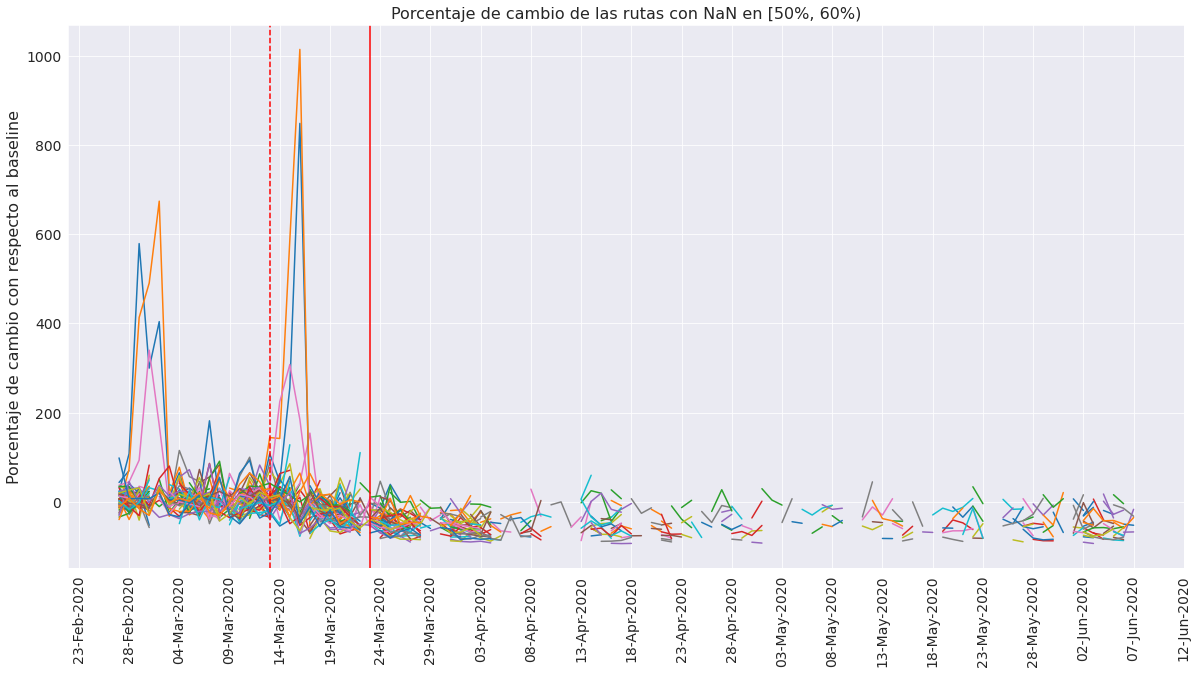

In [89]:
rutas = grupo1.index
dias = grupo1.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo1.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con NaN en [50%, 60%)', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

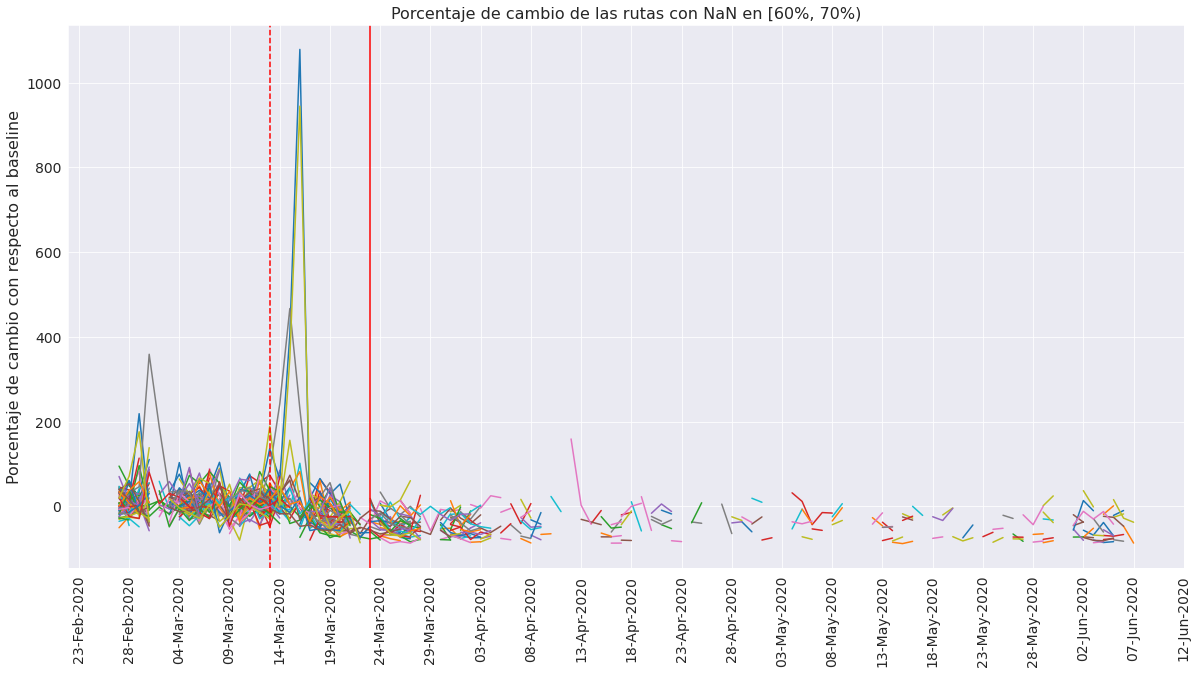

In [90]:
rutas = grupo2.index
dias = grupo2.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo2.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con NaN en [60%, 70%)', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

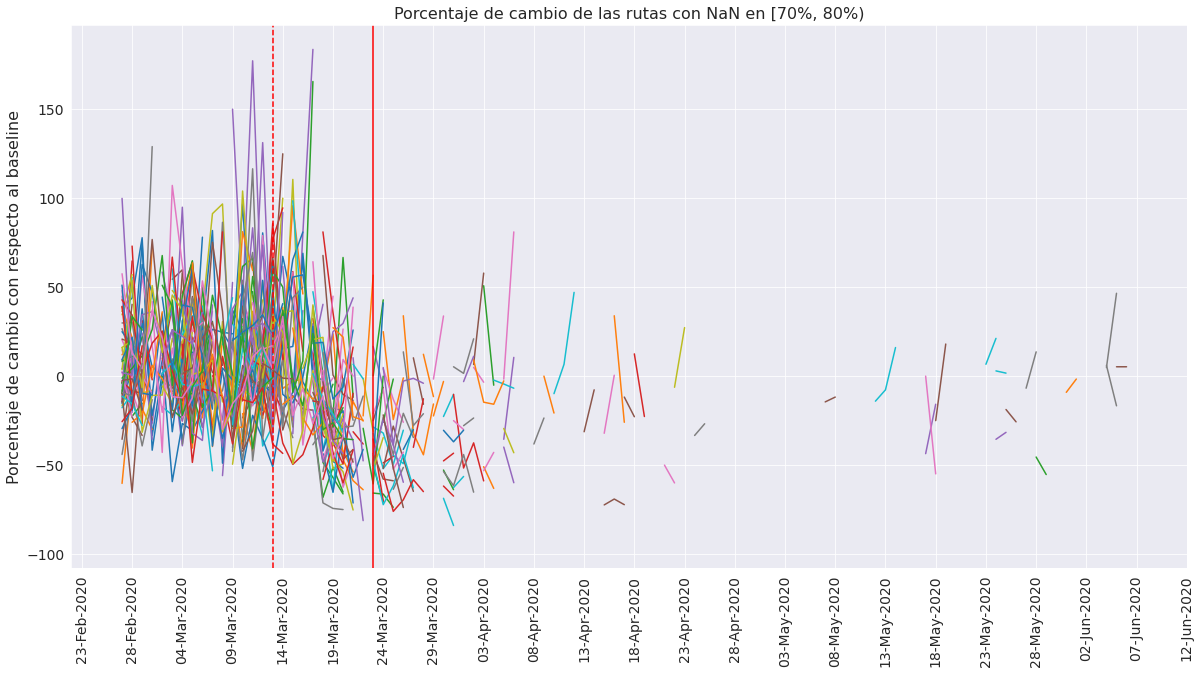

In [91]:
rutas = grupo3.index
dias = grupo3.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo3.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con NaN en [70%, 80%)', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

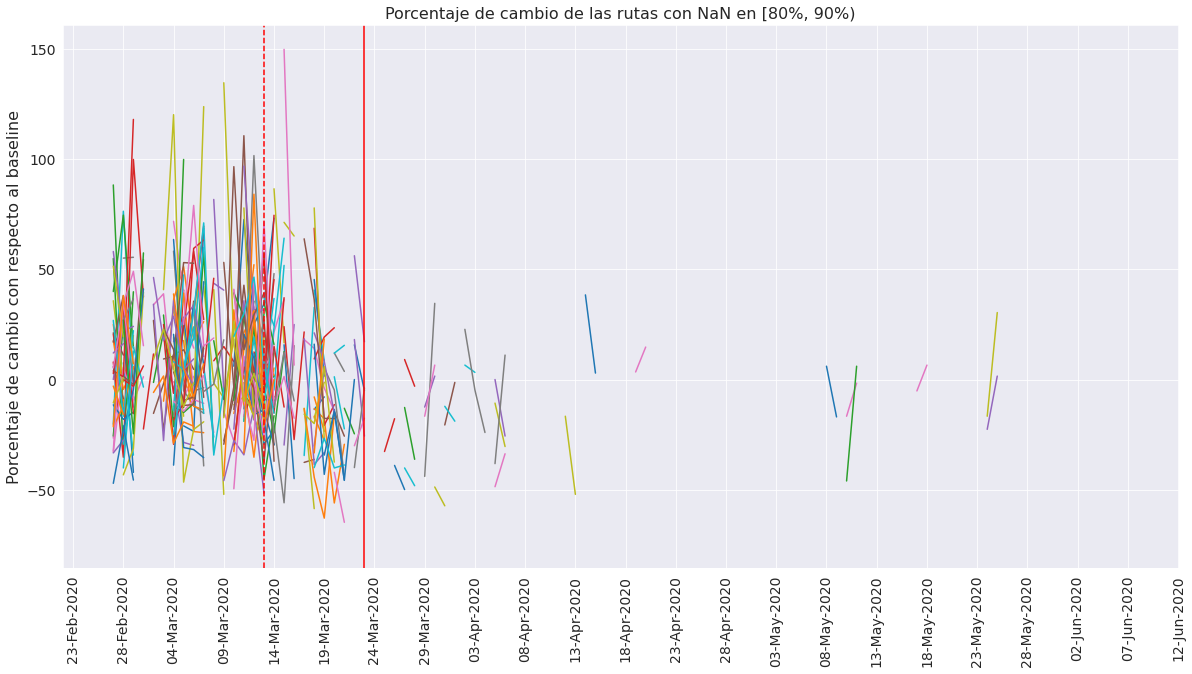

In [92]:
rutas = grupo4.index
dias = grupo4.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo4.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con NaN en [80%, 90%)', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

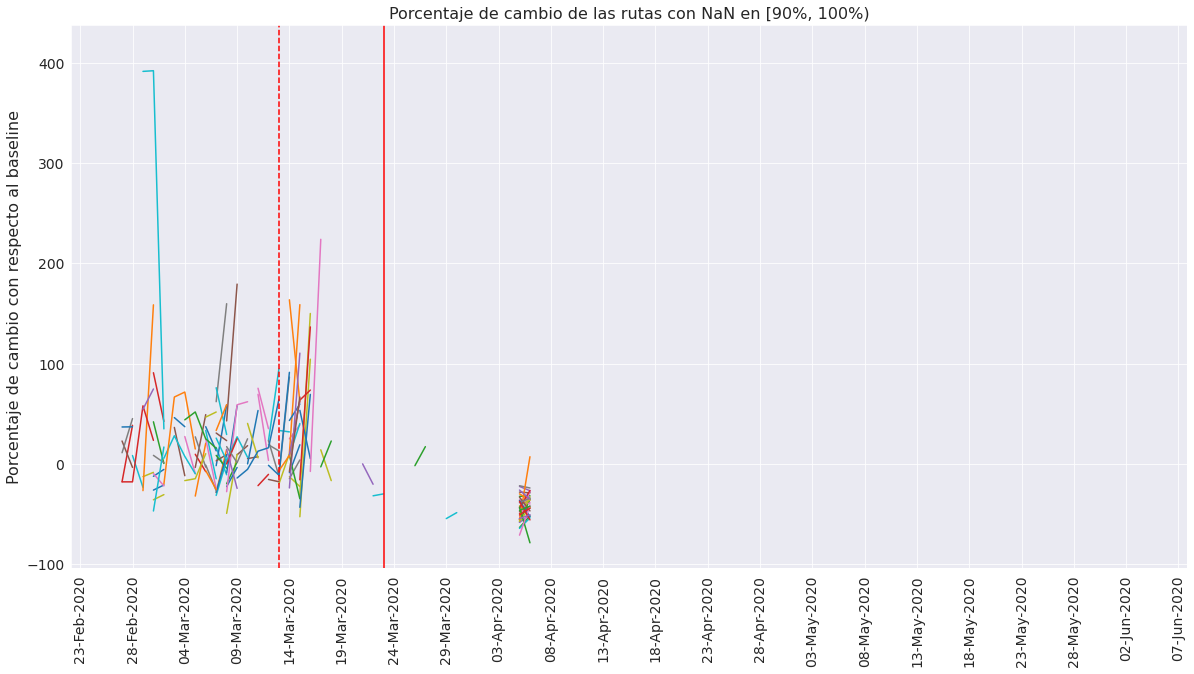

In [93]:
rutas = grupo5.index
dias = grupo5.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo5.loc[ruta, ('percent_change',)])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas con NaN en [90%, 100%)', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

# 8. Porcentaje de cambio en las 100 rutas más transitadas


In [94]:
top100_rutas = df_cambio[df_cambio['Top100']==1][('percent_change',)]

In [95]:
# % de nulos en las top 100 rutas
top100_nan = top100_rutas.isnull().mean(axis=1).sort_values(ascending=False)*100
top100_nan

ruta
Acolman - Acolman                                            0.980392
San Martín de las Pirámides - San Martín de las Pirámides    0.980392
Nicolás Romero - Nicolás Romero                              0.980392
Nezahualcóyotl - Nezahualcóyotl                              0.980392
Chalco - Chalco                                              0.980392
                                                               ...   
Iztacalco - Cuauhtémoc                                       0.000000
Gustavo A. Madero - Gustavo A. Madero                        0.000000
Gustavo A. Madero - Cuauhtémoc                               0.000000
Gustavo A. Madero - Azcapotzalco                             0.000000
Iztapalapa - Benito Juárez                                   0.000000
Length: 100, dtype: float64

In [96]:
# Rutas sin 'Benito Juárez - Benito Juárez'
top100_avg_change = top100_rutas.loc[top100_rutas.index != 'Benito Juárez - Benito Juárez']
top100_avg_change = top100_avg_change.mean(axis=1, skipna=True)

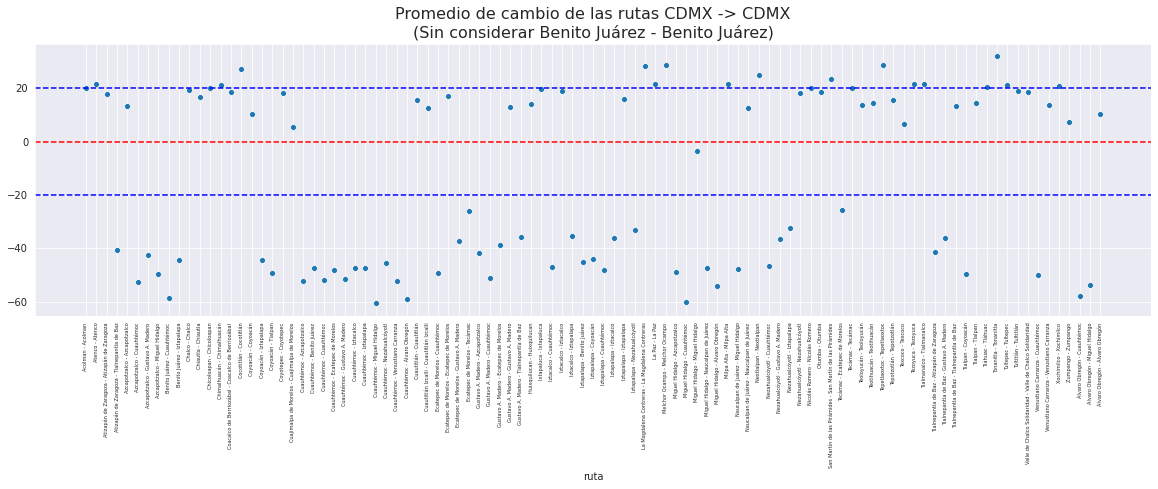

In [97]:
fig, ax = plt.subplots(figsize=(20,5))

ax = sns.scatterplot(x=top100_avg_change.index, y=top100_avg_change.values )
plt.axhline(y=-20, color='blue', linestyle='dashed')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.axhline(y=20, color='blue', linestyle='dashed')


plt.title('Promedio de cambio de las rutas CDMX -> CDMX\n(Sin considerar Benito Juárez - Benito Juárez)', fontsize='16')
plt.xticks(fontsize='5', rotation='vertical')
plt.show()

Dividimos las 100 rutas más transitadas en grupos según el promedio del cambio porcentual en todo el periodo:

| Grupo | Intevalo | No. Rutas |
|:-----:|:--------:|:---------:|
|Grupo 1|[-inf, -20)| 48 |
|Grupo 2|[-20, 0)| 1 |
|Grupo 3|[0, 20)| 30 |
|Grupo 4|[20, inf)| 20 |


In [98]:
bins = [-100, -20, 0, 20, 500]
grupos = pd.cut(top100_avg_change, bins, right = False)

In [99]:
index_grupo1 =  grupos[grupos == grupos.cat.categories[0]].index
grupo1 = top100_rutas.loc[index_grupo1]

index_grupo2 =  grupos[grupos == grupos.cat.categories[1]].index
grupo2 = top100_rutas.loc[index_grupo2]

index_grupo3 =  grupos[grupos == grupos.cat.categories[2]].index
grupo3 = top100_rutas.loc[index_grupo3]

index_grupo4 =  grupos[grupos == grupos.cat.categories[3]].index
grupo4 = top100_rutas.loc[index_grupo4]


In [100]:
print("No. group 1: {}\nNo. group 2: {}\nNo. group 3: {}\nNo. group 4: {}\n".format(grupo1.shape[0], 
                                                                                    grupo2.shape[0],
                                                                                    grupo3.shape[0],
                                                                                    grupo4.shape[0]))

No. group 1: 48
No. group 2: 1
No. group 3: 30
No. group 4: 20



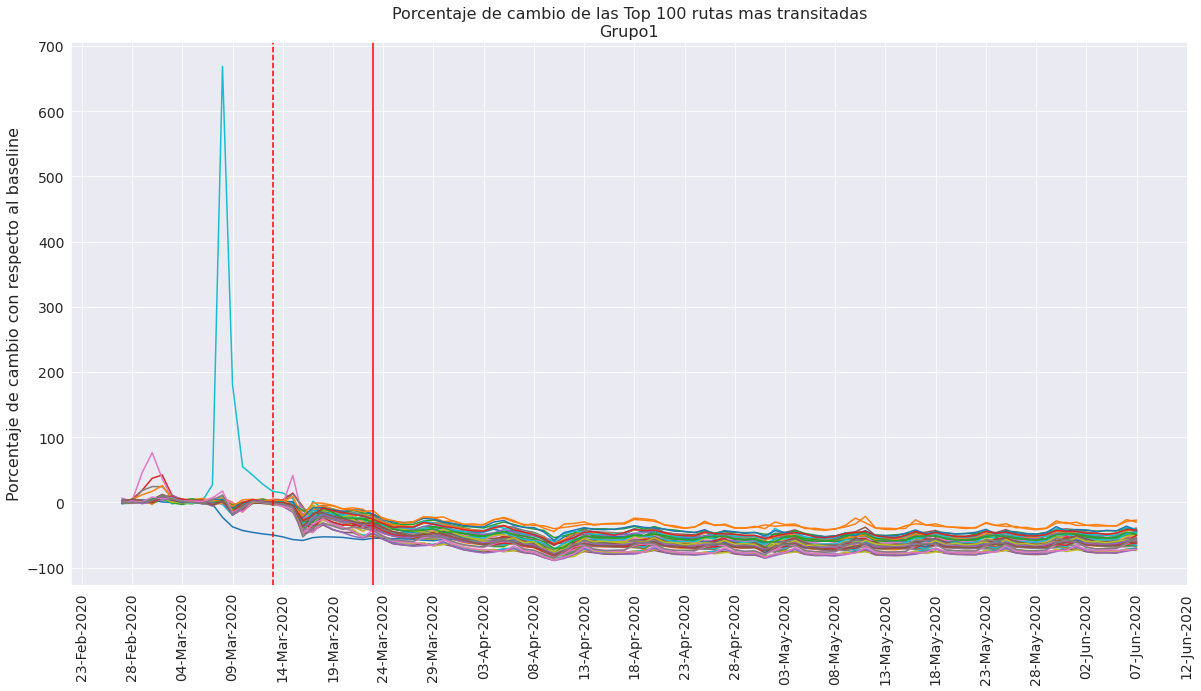

In [101]:
rutas = grupo1.index
dias = grupo1.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo1.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las Top 100 rutas mas transitadas\nGrupo1', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

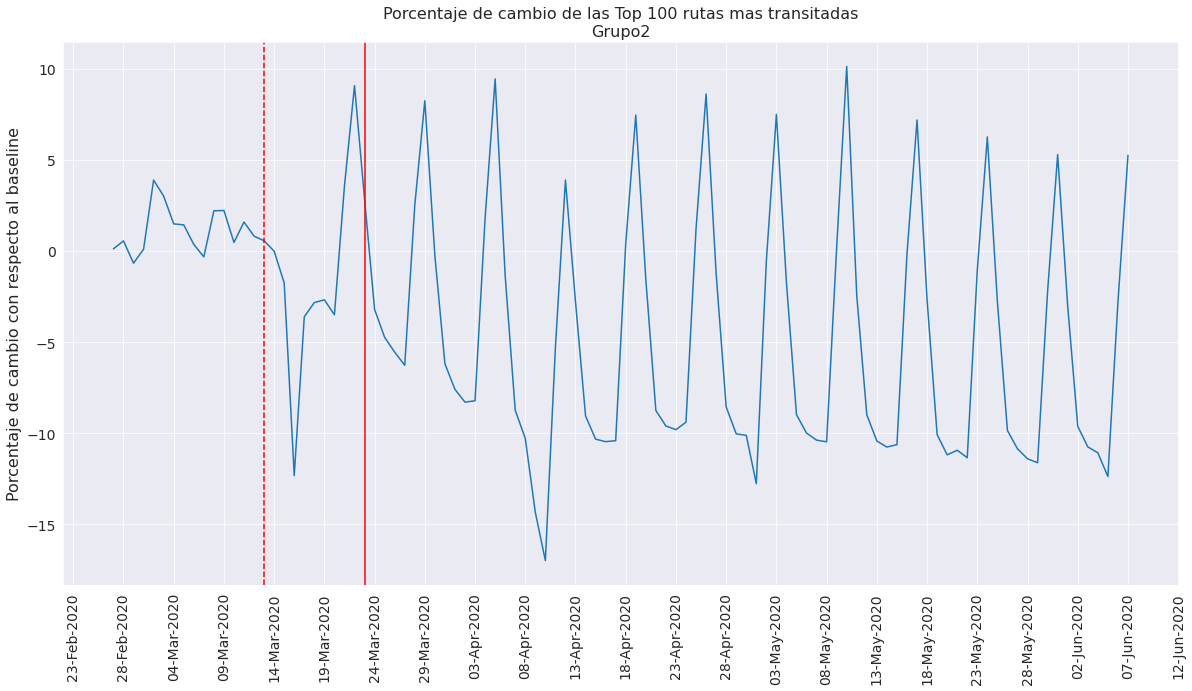

In [102]:
rutas = grupo2.index
dias = grupo2.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo2.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las Top 100 rutas mas transitadas\nGrupo2', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

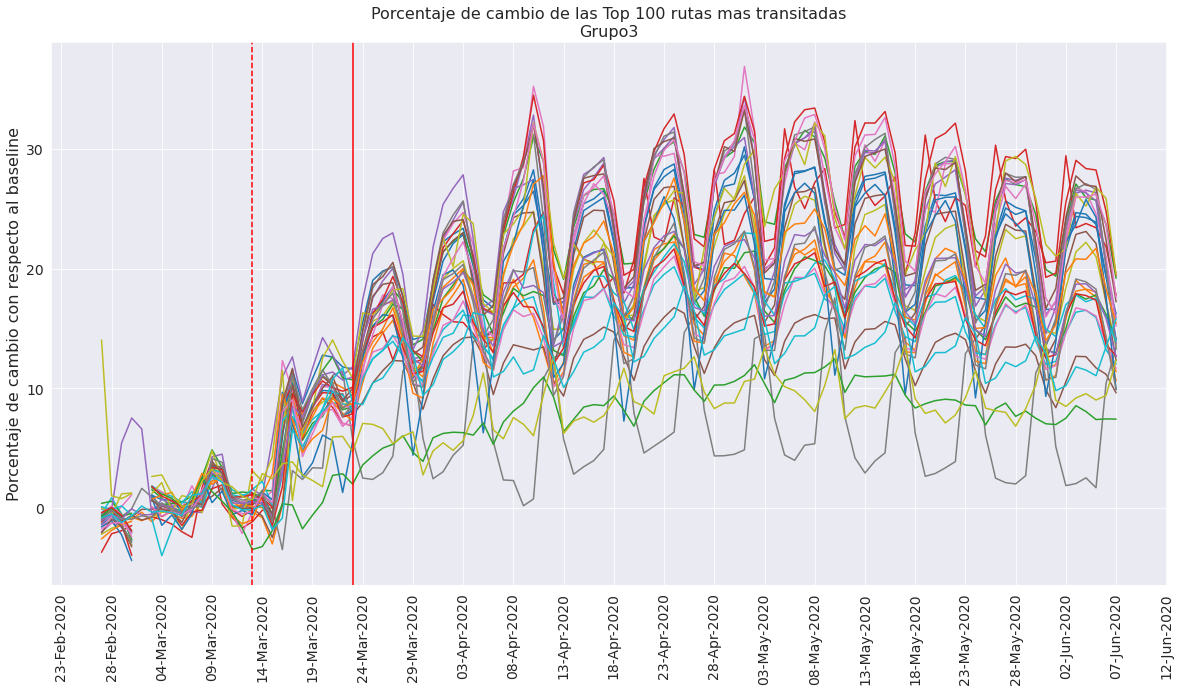

In [103]:
rutas = grupo3.index
dias = grupo3.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo3.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las Top 100 rutas mas transitadas\nGrupo3', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

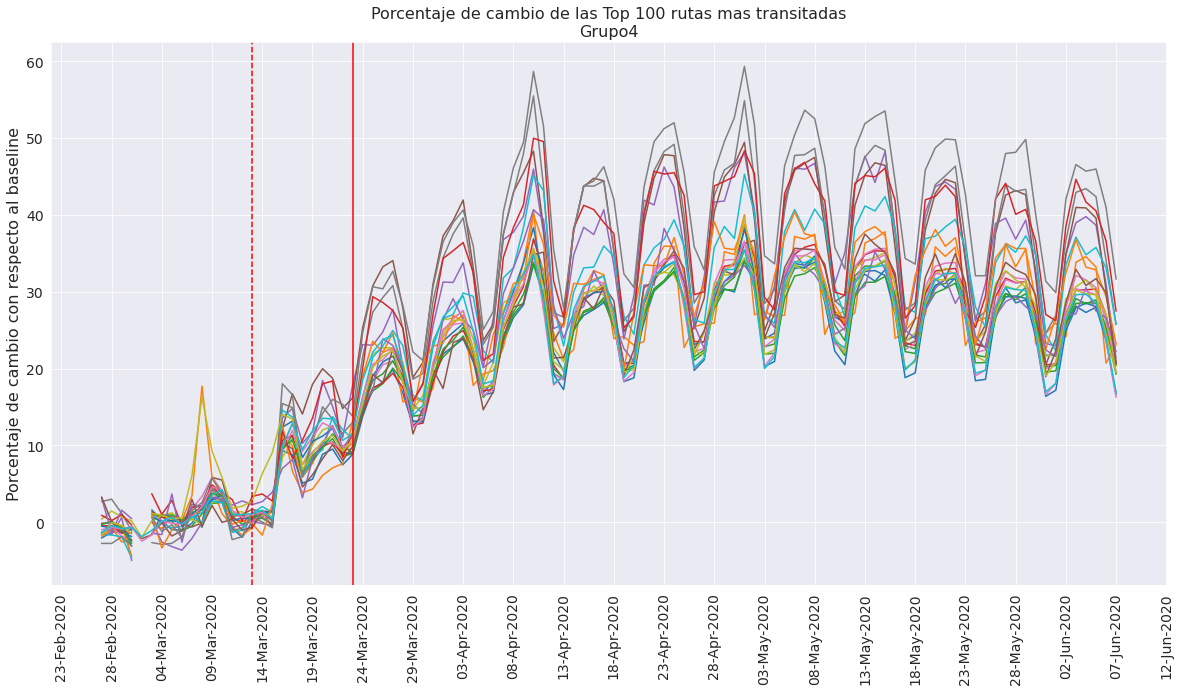

In [104]:
rutas = grupo4.index
dias = grupo4.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo4.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las Top 100 rutas mas transitadas\nGrupo4', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

¿Qué rutas con NaN>50% estan entre las más transitadas?

In [105]:
rutas_des[rutas_des.index.isin(top100_rutas.index)]


Empty DataFrame
Columns: [(percent_change, 2020-02-27 00:00:00), (percent_change, 2020-02-28 00:00:00), (percent_change, 2020-02-29 00:00:00), (percent_change, 2020-03-01 00:00:00), (percent_change, 2020-03-02 00:00:00), (percent_change, 2020-03-03 00:00:00), (percent_change, 2020-03-04 00:00:00), (percent_change, 2020-03-05 00:00:00), (percent_change, 2020-03-06 00:00:00), (percent_change, 2020-03-07 00:00:00), (percent_change, 2020-03-08 00:00:00), (percent_change, 2020-03-09 00:00:00), (percent_change, 2020-03-10 00:00:00), (percent_change, 2020-03-11 00:00:00), (percent_change, 2020-03-12 00:00:00), (percent_change, 2020-03-13 00:00:00), (percent_change, 2020-03-14 00:00:00), (percent_change, 2020-03-15 00:00:00), (percent_change, 2020-03-16 00:00:00), (percent_change, 2020-03-17 00:00:00), (percent_change, 2020-03-18 00:00:00), (percent_change, 2020-03-19 00:00:00), (percent_change, 2020-03-20 00:00:00), (percent_change, 2020-03-21 00:00:00), (percent_change, 2020-03-22 00:00:00), (percent_change, 2020-03-23 00:00:00), (percent_change, 2020-03-24 00:00:00), (percent_change, 2020-03-25 00:00:00), (percent_change, 2020-03-26 00:00:00), (percent_change, 2020-03-27 00:00:00), (percent_change, 2020-03-28 00:00:00), (percent_change, 2020-03-29 00:00:00), (percent_change, 2020-03-30 00:00:00), (percent_change, 2020-03-31 00:00:00), (percent_change, 2020-04-01 00:00:00), (percent_change, 2020-04-02 00:00:00), (percent_change, 2020-04-03 00:00:00), (percent_change, 2020-04-04 00:00:00), (percent_change, 2020-04-05 00:00:00), (percent_change, 2020-04-06 00:00:00), (percent_change, 2020-04-07 00:00:00), (percent_change, 2020-04-08 00:00:00), (percent_change, 2020-04-09 00:00:00), (percent_change, 2020-04-10 00:00:00), (percent_change, 2020-04-11 00:00:00), (percent_change, 2020-04-12 00:00:00), (percent_change, 2020-04-13 00:00:00), (percent_change, 2020-04-14 00:00:00), (percent_change, 2020-04-15 00:00:00), (percent_change, 2020-04-16 00:00:00), (percent_change, 2020-04-17 00:00:00), (percent_change, 2020-04-18 00:00:00), (percent_change, 2020-04-19 00:00:00), (percent_change, 2020-04-20 00:00:00), (percent_change, 2020-04-21 00:00:00), (percent_change, 2020-04-22 00:00:00), (percent_change, 2020-04-23 00:00:00), (percent_change, 2020-04-24 00:00:00), (percent_change, 2020-04-25 00:00:00), (percent_change, 2020-04-26 00:00:00), (percent_change, 2020-04-27 00:00:00), (percent_change, 2020-04-28 00:00:00), (percent_change, 2020-04-29 00:00:00), (percent_change, 2020-04-30 00:00:00), (percent_change, 2020-05-01 00:00:00), (percent_change, 2020-05-02 00:00:00), (percent_change, 2020-05-03 00:00:00), (percent_change, 2020-05-04 00:00:00), (percent_change, 2020-05-05 00:00:00), (percent_change, 2020-05-06 00:00:00), (percent_change, 2020-05-07 00:00:00), (percent_change, 2020-05-08 00:00:00), (percent_change, 2020-05-09 00:00:00), (percent_change, 2020-05-10 00:00:00), (percent_change, 2020-05-11 00:00:00), (percent_change, 2020-05-12 00:00:00), (percent_change, 2020-05-13 00:00:00), (percent_change, 2020-05-14 00:00:00), (percent_change, 2020-05-15 00:00:00), (percent_change, 2020-05-16 00:00:00), (percent_change, 2020-05-17 00:00:00), (percent_change, 2020-05-18 00:00:00), (percent_change, 2020-05-19 00:00:00), (percent_change, 2020-05-20 00:00:00), (percent_change, 2020-05-21 00:00:00), (percent_change, 2020-05-22 00:00:00), (percent_change, 2020-05-23 00:00:00), (percent_change, 2020-05-24 00:00:00), (percent_change, 2020-05-25 00:00:00), (percent_change, 2020-05-26 00:00:00), (percent_change, 2020-05-27 00:00:00), (percent_change, 2020-05-28 00:00:00), (percent_change, 2020-05-29 00:00:00), (percent_change, 2020-05-30 00:00:00), (percent_change, 2020-05-31 00:00:00), (percent_change, 2020-06-01 00:00:00), (percent_change, 2020-06-02 00:00:00), (percent_change, 2020-06-03 00:00:00), (percent_change, 2020-06-04 00:00:00), (percent_change, 2020-06-05 00:00:00), ...]
Index: []

[0 rows x 109 columns]

# 9. Porcentaje de cambio por día de la semana

In [195]:
list_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

ruta_dias = []
i=0
for dia in list_dias:
    df = data[data['dia_semana']==dia][['ruta','percent_change', 'fecha', 'hr']].groupby(['ruta','fecha']).mean().unstack()
    i=1+i
    ruta_dias.append(df)
    

In [196]:
ruta_dias[1]

percent_change             \
fecha                                            2020-03-03 2020-03-10   
ruta                                                                     
Acolman - Acolman                                  1.624456   2.653199   
Acolman - Atenco                                   5.979705   2.144834   
Acolman - Azcapotzalco                           -31.031501  -6.223881   
Acolman - Benito Juárez                           39.175258  49.484536   
Acolman - Chiautla                               -38.144330  49.249527   
...                                                     ...        ...   
Álvaro Obregón - Tultitlán                              NaN -16.152898   
Álvaro Obregón - Valle de Chalco Solidaridad      12.068966 -11.442786   
Álvaro Obregón - Venustiano Carranza               5.455269 -12.816579   
Álvaro Obregón - Xochimilco                        5.156852 -19.878345   
Álvaro Obregón - Álvaro Obregón                   -0.359693   2.156732   

                                                                               \
fecha                                        2020-03-17 2020-03-24 2020-03-31   
ruta                                                                            
Acolman - Acolman                              8.782772  13.779327  18.297253   
Acolman - Atenco                               5.346361 -16.167227 -24.154743   
Acolman - Azcapotzalco                        25.536790 -44.188258 -50.766637   
Acolman - Benito Juárez                       13.402062        NaN -43.298969   
Acolman - Chiautla                            14.594072        NaN  15.307037   
...                                                 ...        ...        ...   
Álvaro Obregón - Tultitlán                   -87.669544 -43.896424 -75.955610   
Álvaro Obregón - Valle de Chalco Solidaridad -48.850575 -20.243610 -32.595642   
Álvaro Obregón - Venustiano Carranza         -35.674703 -59.320374 -67.242948   
Álvaro Obregón - Xochimilco                  -53.006531 -53.767198 -66.943138   
Álvaro Obregón - Álvaro Obregón                6.541601   8.628107  10.287238   

                                                                               \
fecha                                        2020-04-07 2020-04-14 2020-04-21   
ruta                                                                            
Acolman - Acolman                             23.420500  25.226152  25.990687   
Acolman - Atenco                             -24.926211 -22.199791 -24.363848   
Acolman - Azcapotzalco                       -59.859642 -41.176471 -45.319480   
Acolman - Benito Juárez                      -32.989691        NaN        NaN   
Acolman - Chiautla                            -4.415061 -43.298969 -18.750000   
...                                                 ...        ...        ...   
Álvaro Obregón - Tultitlán                   -83.353884 -85.819975 -80.271270   
Álvaro Obregón - Valle de Chalco Solidaridad -42.052668 -57.711443 -53.905044   
Álvaro Obregón - Venustiano Carranza         -77.221653 -79.183876 -76.655494   
Álvaro Obregón - Xochimilco                  -73.887654 -76.254844 -73.255262   
Álvaro Obregón - Álvaro Obregón               11.401581  11.395952  12.662840   

                                                                    ...  \
fecha                                        2020-04-28 2020-05-05  ...   
ruta                                                                ...   
Acolman - Acolman                             28.779142  31.854567  ...   
Acolman - Atenco                             -21.727009 -37.989292  ...   
Acolman - Azcapotzalco                       -52.229299 -60.529729  ...   
Acolman - Benito Juárez                             NaN        NaN  ...   
Acolman - Chiautla                           -15.284626 -19.393396  ...   
...                                                 ...        ...  ...   
Álvaro Obregón - Tultitlán                   -88.286067 -89.519

## 9.1 Para las 100 rutas mas transitadas

In [190]:
ruta_dias[0].loc[ruta_dias[0].index.get_level_values(0).isin(top100_rutas.index)]


percent_change             \
fecha                                           2020-03-02 2020-03-09   
ruta                                                                    
Acolman - Acolman                                      NaN   4.224211   
Atenco - Atenco                                        NaN   4.550850   
Atizapán de Zaragoza - Atizapán de Zaragoza            NaN   2.716909   
Atizapán de Zaragoza - Tlalnepantla de Baz             NaN -11.201506   
Azcapotzalco - Azcapotzalco                      -0.352949   3.334810   
...                                                    ...        ...   
Xochimilco - Xochimilco                          -1.875470   3.512971   
Zumpango - Zumpango                                    NaN   3.261520   
Álvaro Obregón - Cuauhtémoc                       5.368081 -15.413675   
Álvaro Obregón - Miguel Hidalgo                  10.396120 -18.103783   
Álvaro Obregón - Álvaro Obregón                   0.160715   2.637796   

                                                                              \
fecha                                       2020-03-16 2020-03-23 2020-03-30   
ruta                                                                           
Acolman - Acolman                             9.341844   8.837632  13.674022   
Atenco - Atenco                              11.134442  10.295202  15.654161   
Atizapán de Zaragoza - Atizapán de Zaragoza   5.855961  11.606130  14.331421   
Atizapán de Zaragoza - Tlalnepantla de Baz  -38.418647 -22.758328 -38.136872   
Azcapotzalco - Azcapotzalco                   0.217596   9.598169  10.941794   
...                                                ...        ...        ...   
Xochimilco - Xochimilco                       9.915647  11.518757  15.250822   
Zumpango - Zumpango                           3.693311   4.702139   2.755993   
Álvaro Obregón - Cuauhtémoc                 -48.685342 -41.823015 -57.301885   
Álvaro Obregón - Miguel Hidalgo             -52.872318 -42.489988 -53.957861   
Álvaro Obregón - Álvaro Obregón              -0.847452   8.820615   9.397074   

                                                                              \
fecha                                       2020-04-06 2020-04-13 2020-04-20   
ruta                                                                           
Acolman - Acolman                            18.336616  19.665613  21.041745   
Atenco - Atenco                              19.742562  21.187629  23.032965   
Atizapán de Zaragoza - Atizapán de Zaragoza  16.712985  17.175970  18.413318   
Atizapán de Zaragoza - Tlalnepantla de Baz  -44.861318 -45.415191 -43.502727   
Azcapotzalco - Azcapotzalco                  12.950572  12.218523  14.021826   
...                                                ...        ...        ...   
Xochimilco - Xochimilco                      18.424342  19.069300  20.440161   
Zumpango - Zumpango                           6.535854   6.214966   8.883026   
Álvaro Obregón - Cuauhtémoc                 -66.713493 -68.295198 -67.054274   
Álvaro Obregón - Miguel Hidalgo             -62.299289 -64.481406 -63.454903   
Álvaro Obregón - Álvaro Obregón              10.940307  10.058653  12.206215   

                                                                   ...  \
fecha                                       2020-04-27 2020-05-04  ...   
ruta                                                               ...   
Acolman - Acolman                            23.541362  24.628810  ...   
Atenco - Atenco                              25.820937  26.829308  ...   
Atizapán de Zaragoza - Atizapán de Zaragoza  19.872191  19.075317  ...   
Atizapán de Zaragoza - Tlalnepantla de Baz  -48.656901 -46.821585  ...   
Azcapotzalco - Azcapotzalco                  14.400303  13.961361  ...   
...                                                ...        ...  ...   
Xochimilco - Xochimilco                      21.344366  21.606970  ...   
Zumpango - Zumpango                    

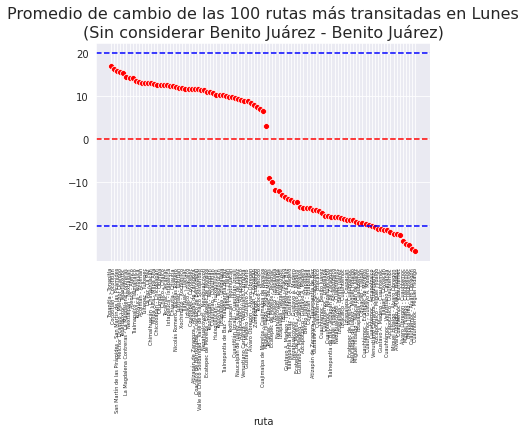

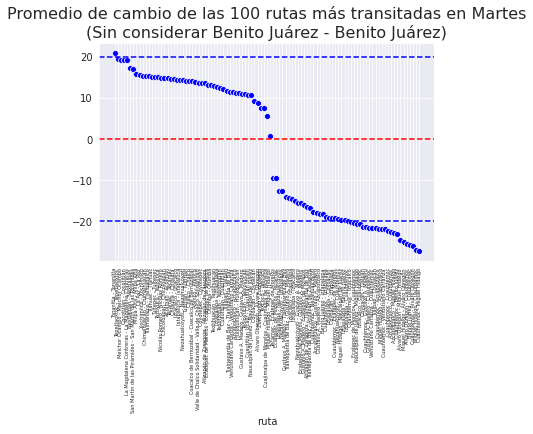

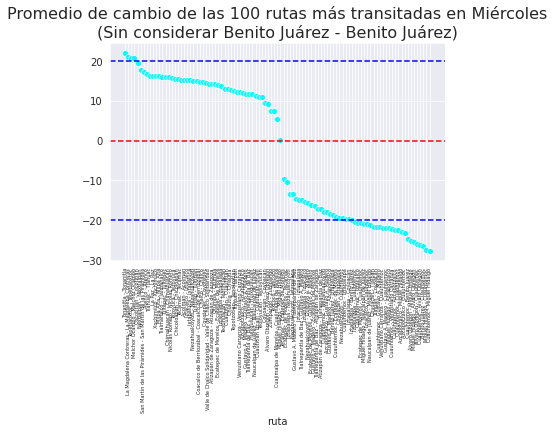

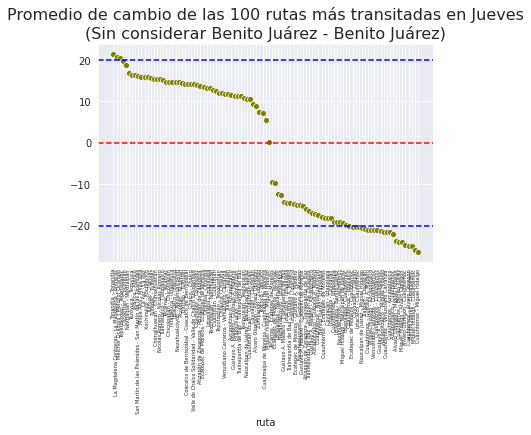

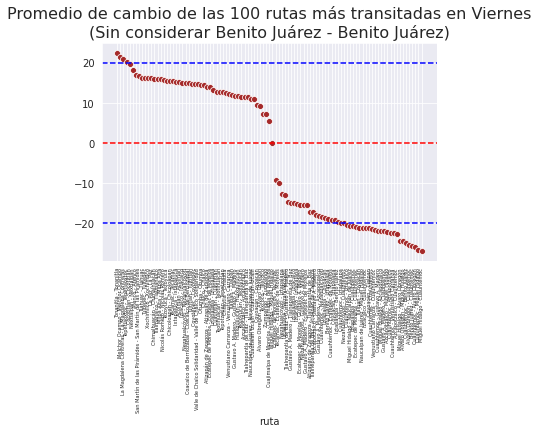

In [197]:
colors = ['red', 'blue', 'cyan', 'olive', 'brown', 'black', 'darkorchid']

#fig, ax = plt.subplots(7, figsize=(20,5))

for i in range(0,5):
    ruta_dia_top100 = ruta_dias[i].loc[ruta_dias[i].index.get_level_values(0).isin(top100_rutas.index)]

    #Sin Benito Juárez - Benito Juárez
    ruta_dia_top100_avg = ruta_dia_top100.mean(axis=1).sort_values(ascending=False)
    ruta_dia_top100_avg = ruta_dia_top100_avg[ruta_dia_top100_avg.index != 'Benito Juárez - Benito Juárez']
    
    ax[i] = sns.scatterplot(x=ruta_dia_top100_avg.index, y=ruta_dia_top100_avg.values, color=colors[i] )
    plt.axhline(y=-20, color='blue', linestyle='dashed')
    plt.axhline(y=0, color='red', linestyle='dashed')
    plt.axhline(y=20, color='blue', linestyle='dashed')
    
    plt.title('Promedio de cambio de las 100 rutas más transitadas en {}\n(Sin considerar Benito Juárez - Benito Juárez)'.format(list_dias[i]), fontsize='16')
    plt.xticks(fontsize='5', rotation='vertical')
    plt.show()

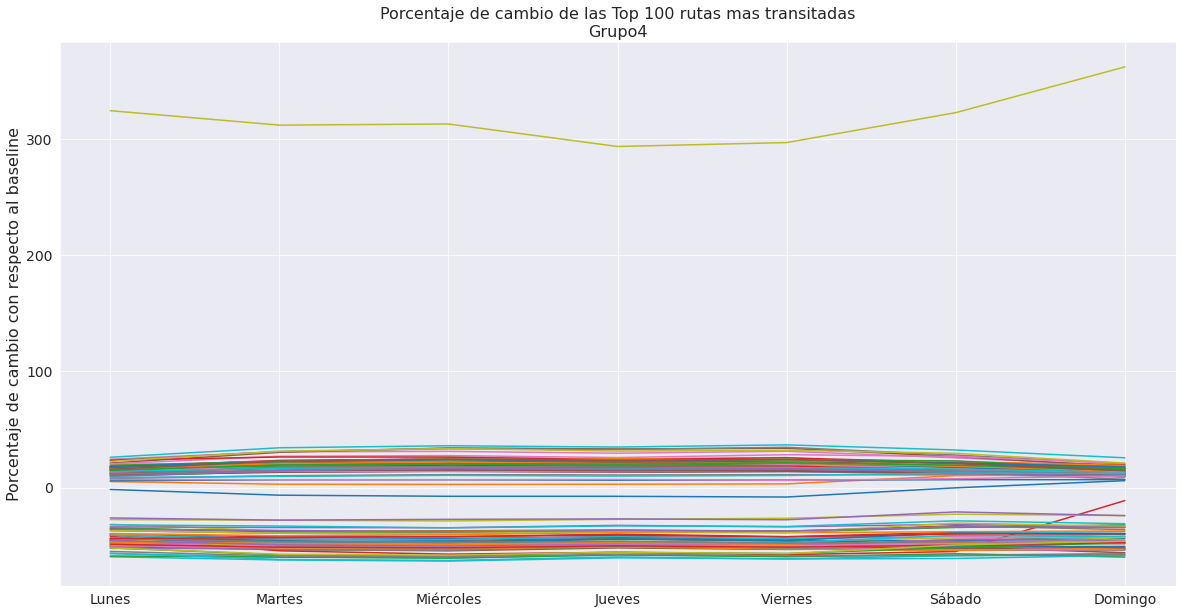

In [186]:
rutas = ruta_dia_top100.index
dias = ruta_dia_top100.columns.get_level_values(1)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(ruta_dia.loc[ruta, ('percent_change',)])

plt.title('Porcentaje de cambio de las Top 100 rutas mas transitadas\nGrupo4', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.show()

# Findings

De los datos:
   - Se tienen datos de 102 dias, desde 2020-02-27 al 2020-06-07, en ventanas de 8 horas.
   - Existen 5,433 registros repetidos de la base original de 284,495. Eliminados los repetidos, se tienen 279,062 registros restantes.
   - En el 0.14% de los casos, el baseline original de la base no es consistente, es decir, para ciertos dias se compara ocn un baseline distinto
    - Existen 1,571 rutas únicas en la base. Considerando las ventanas de tiempo, hay 1,438 ruta únicas a las 00 horas, 1,206 a las 08 horas y 1,316 las 16 horas.


De lo que podemos interpretar:
   - Las rutas con origen y destino fuera de la CDMX representan el 40% de las rutas en la base, mientras que las que tienen origen y destino en la CDMX son el 23.7%. 
   - La distribución de las rutas por hora, según su origen destino, se mantiene casi constante a lo largo de las 3 ventanas de tiempo para las rutas con origen y destino fuera de la CDMX.
   - Para las rutas con origen y destino en la CDMX, también se mantuvieron relativamente constantes a lo largo del día.
   - Las rutas con origen fuera de la CDMX y destino en la CDMX concentraron el 22% y 20% a las 8 y 16 horas, pero disminuyeron hasta 14% para las 00 horas. Inversamente, las rutas con origen en la CDMX y destino fuera de la CDMX aumentaron a 23% a las 00 horas, de 13% y 16% a las 8 y 6 horas.
   - En términos del número de personas que transitan las rutas el 95% se reparte entre rutas con origen y destino en la CDMX y, rutas con origen y destino fuera de la CDMX. El restante 5% de las personas que transitan, lo hace de municipios fuera de la CDMX a las alcaldías de la CDMX o viceversa.
   - Las 100 rutas más transitadas durante la “crisis” transportaron al 92% de las personas que  se movieron. Las principales rutas, nuevamente, se encontraron dentro de la CDMX y entre municipios fuera de la CDMX.
   - El 75.82% de las rutas tienen una longitud menor o igual a 20km
